<a href="https://colab.research.google.com/github/mayuridev/DeepQueryImprovisation/blob/main/musicML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/MusicNotebook/

/content/drive/MyDrive/MusicNotebook


In [ ]:
!apt-get install swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 31 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 2s (450 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpacking 

In [ ]:
!git clone https://github.com/louisabraham/python3-midi.git

fatal: destination path 'python3-midi' already exists and is not an empty directory.


In [ ]:
cd python3-midi/

/content/drive/My Drive/MusicNotebook/python3-midi


In [ ]:
!python setup.py install

/usr/local/lib/python2.7/dist-packages/setuptools/dist.py:476: UserWarning: Normalizing 'v0.2.3' to '0.2.3'
  normalized_version,
running install
running build_ext
running build
running build_py
running build_scripts
changing mode of build/scripts-2.7/mididump.py from 600 to 755
changing mode of build/scripts-2.7/mididumphw.py from 600 to 755
changing mode of build/scripts-2.7/midiplay.py from 600 to 755
running install_lib
creating /usr/local/lib/python2.7/dist-packages/midi
copying build/lib.linux-x86_64-2.7/midi/constants.py -> /usr/local/lib/python2.7/dist-packages/midi
copying build/lib.linux-x86_64-2.7/midi/events.py -> /usr/local/lib/python2.7/dist-packages/midi
copying build/lib.linux-x86_64-2.7/midi/fileio.py -> /usr/local/lib/python2.7/dist-packages/midi
copying build/lib.linux-x86_64-2.7/midi/util.py -> /usr/local/lib/python2.7/dist-packages/midi
copying build/lib.linux-x86_64-2.7/midi/containers.py -> /usr/local/lib/python2.7/dist-packages/midi
copying build/lib.linux-x86_6

In [ ]:
cd ../

/content/drive/My Drive/MusicNotebook


In [ ]:
!pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 34kB/s 
     |████████████████████████████████| 3.8MB 51.9MB/s 
     |████████████████████████████████| 512kB 35.1MB/s 
  Found existing installation: tensorboard 2.1.0
    Uninstalling tensorboard-2.1.0:
      Successfully uninstalled tensorboard-2.1.0
  Found existing installation: tensorflow-estimator 1.15.0
    Uninstalling tensorflow-estimator-1.15.0:
      Successfully uninstalled tensorflow-estimator-1.15.0
  Found existing installation: tensorflow 2.1.0
    Uninstalling tensorflow-2.1.0:
      Successfully uninstalled tensorflow-2.1.0


In [ ]:
import numpy as np
import pandas as pd
import msgpack
import glob
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import midi_manipulation


%matplotlib inline

W0410 20:22:40.569314 140129655117696 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/tensorflow_estimator/python/estimator/api/_v1/estimator/__init__.py:12: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



In [ ]:
def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    print(files)
    songs = []
    for f in tqdm(files):
        print(f)
        song = np.array(midi_manipulation.midiToNoteStateMatrix(f))
        if np.array(song).shape[0] > 50:
             songs.append(song)
             print('gottcha')
        else:
             print(np.array(song).shape[0], 'no good')   
    return songs

In [ ]:
songs = get_songs('/content/drive/MyDrive/mozart/') #These songs have already been converted from midi to msgpack
print("{} songs processed".format(len(songs)))

  0%|          | 0/7 [00:00<?, ?it/s]

['/content/drive/MyDrive/mozart/mz570.mid', '/content/drive/MyDrive/mozart/mz545.mid', '/content/drive/MyDrive/mozart/mz333.mid', '/content/drive/MyDrive/mozart/mz332.mid', '/content/drive/MyDrive/mozart/mz331.mid', '/content/drive/MyDrive/mozart/mz330.mid', '/content/drive/MyDrive/mozart/mz311.mid']
/content/drive/MyDrive/mozart/mz570.mid


 14%|█▍        | 1/7 [00:01<00:06,  1.02s/it]

(1, 'no good')
/content/drive/MyDrive/mozart/mz545.mid


 29%|██▊       | 2/7 [00:02<00:05,  1.19s/it]

gottcha
/content/drive/MyDrive/mozart/mz333.mid


 43%|████▎     | 3/7 [00:05<00:06,  1.58s/it]

gottcha
/content/drive/MyDrive/mozart/mz332.mid


 57%|█████▋    | 4/7 [00:05<00:04,  1.35s/it]

(1, 'no good')
/content/drive/MyDrive/mozart/mz331.mid


 71%|███████▏  | 5/7 [00:06<00:02,  1.20s/it]

(1, 'no good')
/content/drive/MyDrive/mozart/mz330.mid


 86%|████████▌ | 6/7 [00:08<00:01,  1.31s/it]

gottcha
/content/drive/MyDrive/mozart/mz311.mid


100%|██████████| 7/7 [00:10<00:00,  1.59s/it]

gottcha
4 songs processed


In [ ]:
lowest_note = midi_manipulation.lowerBound #the index of the lowest note on the piano roll
highest_note = midi_manipulation.upperBound #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps  = 4 #64 #32 #16 #This is the number of timesteps that we will create at a time  (16 = one bar)
n_visible      = 2*note_range*num_timesteps #This is the size of the visible layer. 
n_hidden       = 600 #50 #This is the size of the hidden layer

In [ ]:
#x  = tf.placeholder(tf.float32, [None, n_visible], name="x") #The placeholder variable that holds our data
#W  = tf.Variable(tf.random_normal([n_visible, n_hidden], 0.01), name="W") #The weight matrix that stores the edge weights
#bh = tf.Variable(tf.zeros([1, n_hidden],  tf.float32, name="bh")) #The bias vector for the hidden layer
#bv = tf.Variable(tf.zeros([1, n_visible],  tf.float32, name="bv")) #The bias vector for the visible layer

In [ ]:
z_dim = n_hidden #100
X_dim = n_visible #mnist.train.images.shape[1]
h_dim = n_hidden #128


In [ ]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [ ]:
tf.__version__

'1.15.0'

In [ ]:
X = tf.placeholder(tf.float32, shape=[None, X_dim], name="X")
z = tf.placeholder(tf.float32, shape=[None, z_dim], name="z")

Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]), name="Q_b1")
Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]), name="Q_W1")

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]), name="Q_W2_mu")
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]), name="Q_b2_mu")

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]),name="Q_W2_sigma")
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]),name="Q_b2_sigma")

In [ ]:
def Q(X):
    h = tf.nn.relu(tf.matmul(X, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

In [ ]:
# =============================== P(X|z) ======================================

P_W1 = tf.Variable(xavier_init([z_dim, h_dim]), name="P_W1")
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]), name="P_b1")

P_b2 = tf.Variable(tf.zeros(shape=[X_dim]), name="P_b2")
P_W2 = tf.Variable(xavier_init([h_dim, X_dim]), name="P_W2")



def P(z):
    h = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

In [ ]:
z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample)

# Sampling from random z
X_samples, _ = P(z)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer().minimize(vae_loss) #check learning rate

#saver = tf.train.Saver()

W0410 20:24:31.334772 140129655117696 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

Iter: 0
Loss: 206.8
[0.]
[206.77296448]


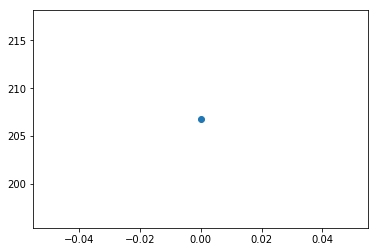

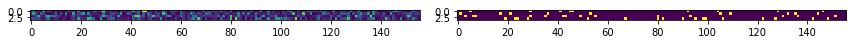

Iter: 100
Loss: 26.47
[  0. 100.]
[206.77296448  26.47010231]


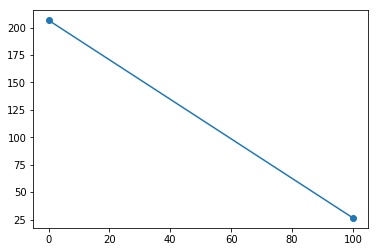

Iter: 200
Loss: 23.75
[  0. 100. 200.]
[206.77296448  26.47010231  23.75245667]


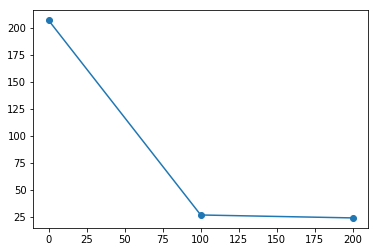

Iter: 300
Loss: 23.58
[  0. 100. 200. 300.]
[206.77296448  26.47010231  23.75245667  23.58371162]


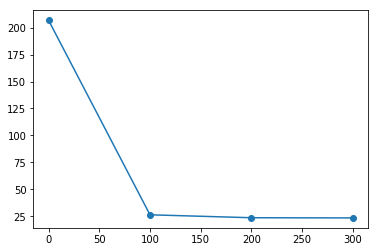

Iter: 400
Loss: 21.87
[  0. 100. 200. 300. 400.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015]


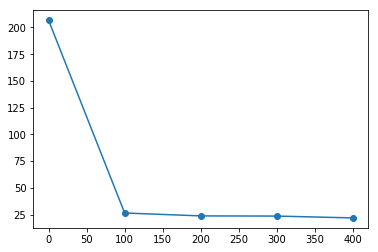

Iter: 500
Loss: 20.11
[  0. 100. 200. 300. 400. 500.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589]


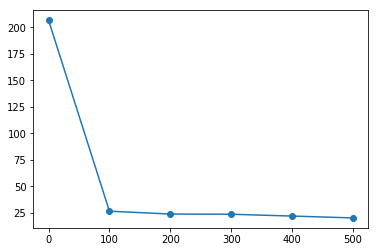

Iter: 600
Loss: 21.92
[  0. 100. 200. 300. 400. 500. 600.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919]


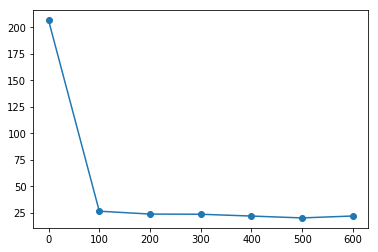

Iter: 700
Loss: 19.79
[  0. 100. 200. 300. 400. 500. 600. 700.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504]


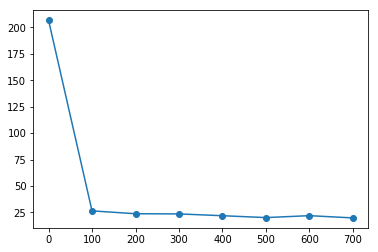

Iter: 800
Loss: 19.58
[  0. 100. 200. 300. 400. 500. 600. 700. 800.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792]


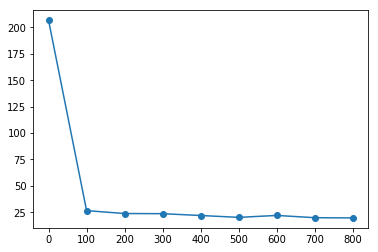

Iter: 900
Loss: 19.94
[  0. 100. 200. 300. 400. 500. 600. 700. 800. 900.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095]


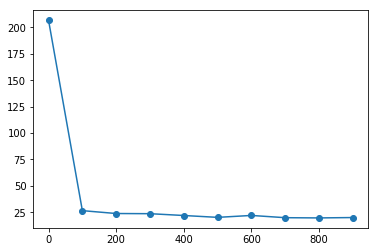

Iter: 1000
Loss: 19.52
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064]


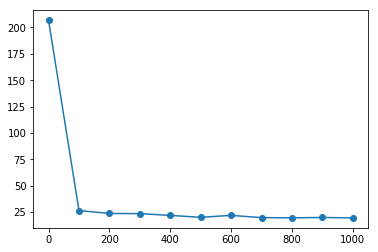

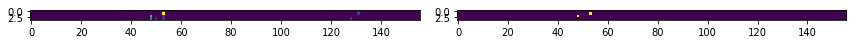

Iter: 1100
Loss: 19.49
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991]


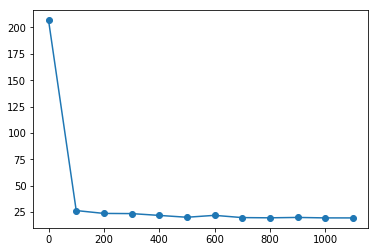

Iter: 1200
Loss: 21.58
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073]


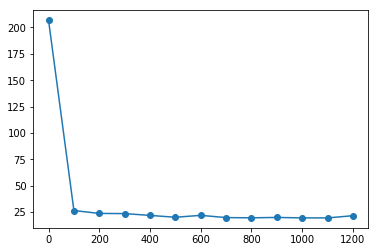

Iter: 1300
Loss: 18.58
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896]


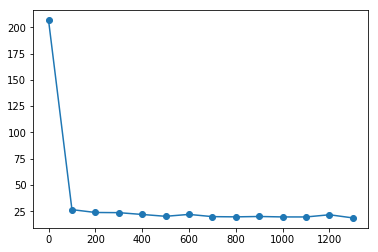

Iter: 1400
Loss: 18.46
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303]


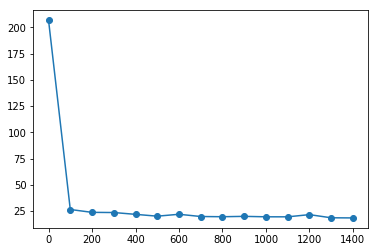

Iter: 1500
Loss: 17.7
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919]


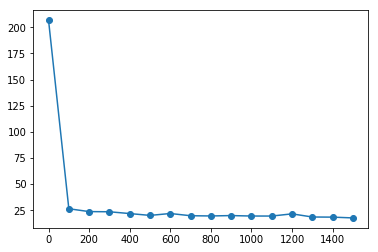

Iter: 1600
Loss: 17.49
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405]


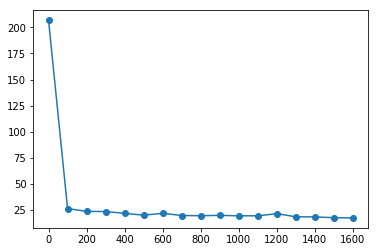

Iter: 1700
Loss: 17.02
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149 ]


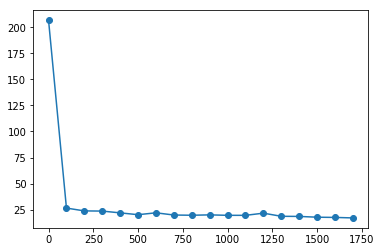

Iter: 1800
Loss: 17.05
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064]


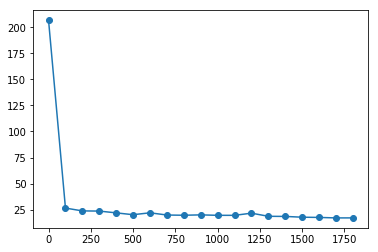

Iter: 1900
Loss: 16.55
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592 ]


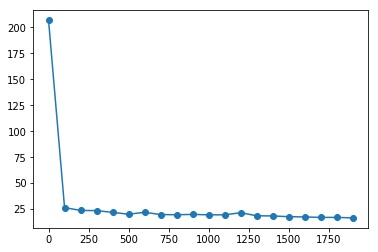

Iter: 2000
Loss: 16.03
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046]


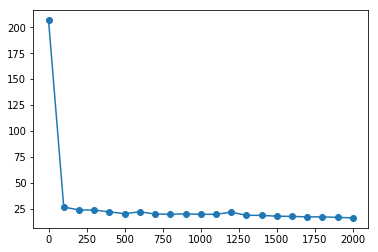

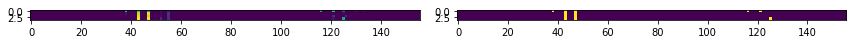

Iter: 2100
Loss: 16.52
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307 ]


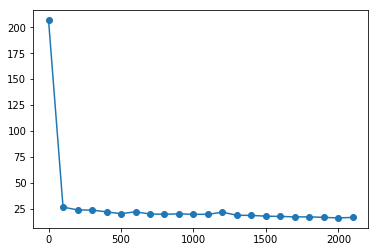

Iter: 2200
Loss: 14.63
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593]


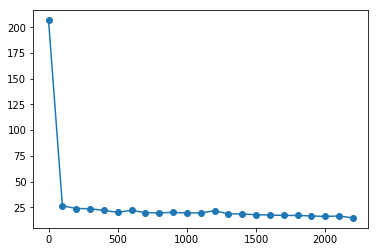

Iter: 2300
Loss: 14.29
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202]


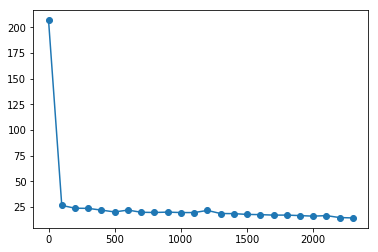

Iter: 2400
Loss: 14.98
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407 ]


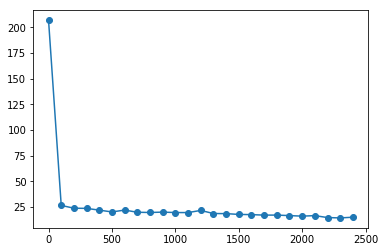

Iter: 2500
Loss: 14.87
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018]


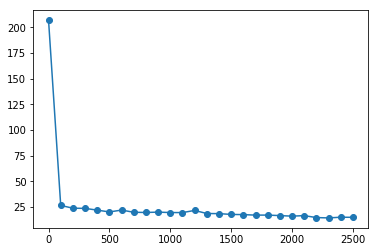

Iter: 2600
Loss: 15.11
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851]


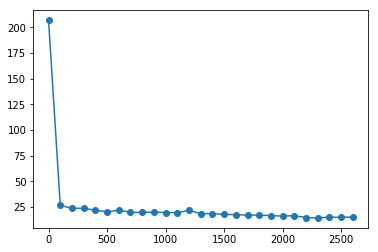

Iter: 2700
Loss: 13.37
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938]


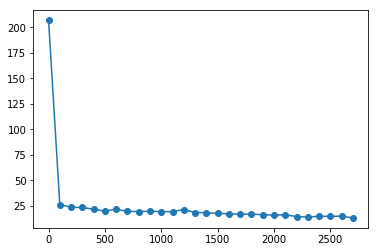

Iter: 2800
Loss: 13.14
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626]


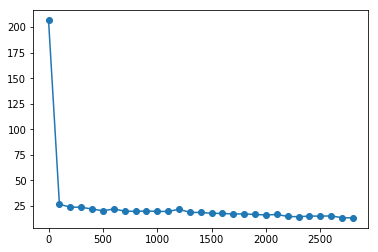

Iter: 2900
Loss: 13.79
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933 ]


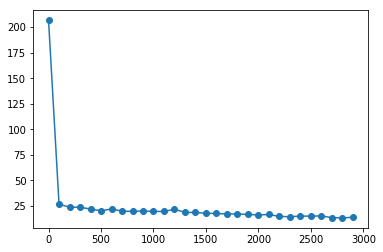

Iter: 3000
Loss: 12.66
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141]


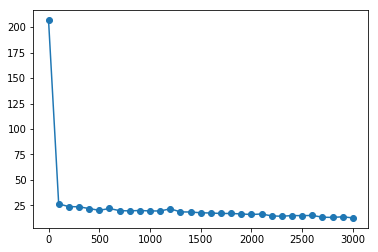

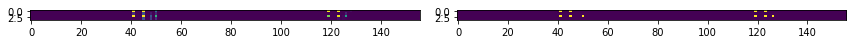

Iter: 3100
Loss: 12.84
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613]


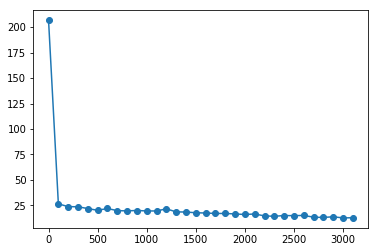

Iter: 3200
Loss: 11.84
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273]


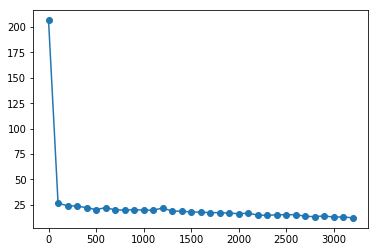

Iter: 3300
Loss: 12.14
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215]


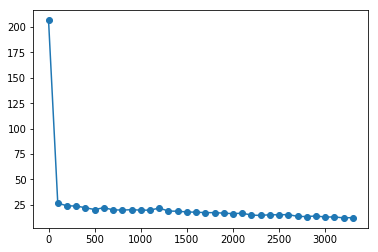

Iter: 3400
Loss: 11.88
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865 ]


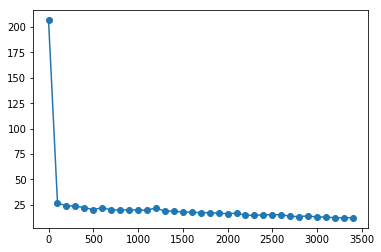

Iter: 3500
Loss: 11.77
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569]


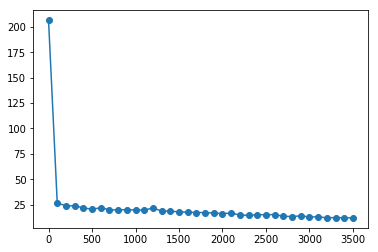

Iter: 3600
Loss: 11.9
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331]


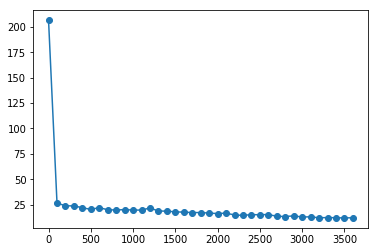

Iter: 3700
Loss: 12.51
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187]


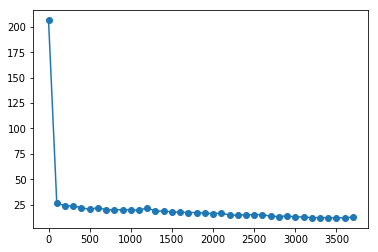

Iter: 3800
Loss: 11.16
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354]


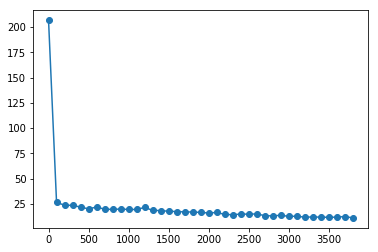

Iter: 3900
Loss: 11.22
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603]


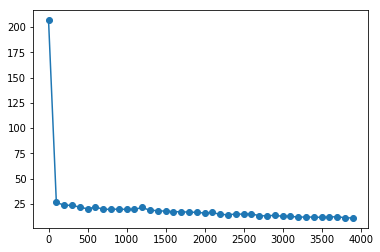

Iter: 4000
Loss: 10.9
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102]


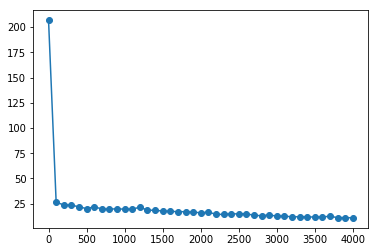

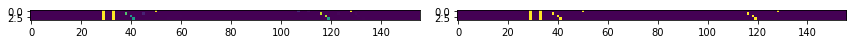

Iter: 4100
Loss: 11.16
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357]


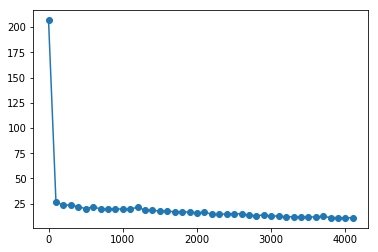

Iter: 4200
Loss: 10.9
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808]


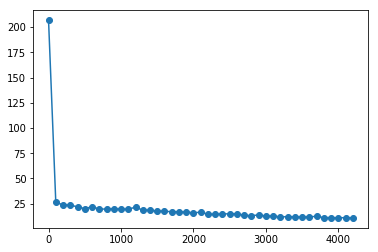

Iter: 4300
Loss: 11.2
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173]


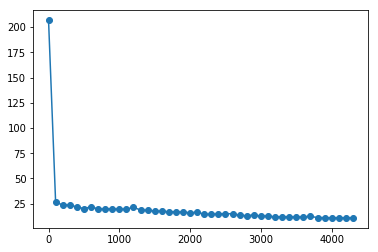

Iter: 4400
Loss: 11.11
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367]


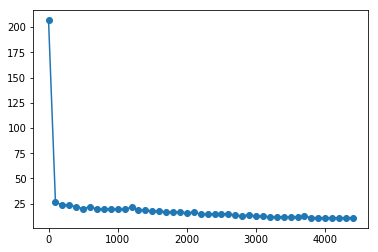

Iter: 4500
Loss: 10.88
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.87773132]


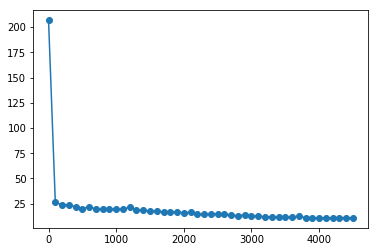

Iter: 4600
Loss: 10.71
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.87773132  10.708498  ]


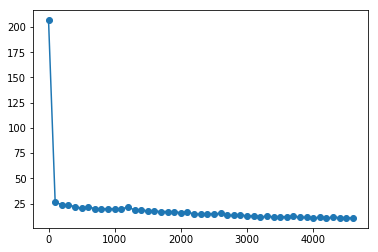

Iter: 4700
Loss: 11.38
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.87773132  10.708498    11.38479137]


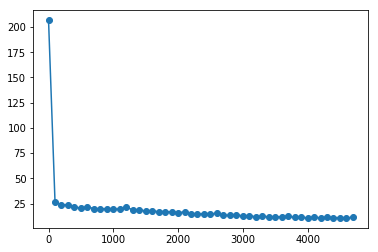

Iter: 4800
Loss: 10.75
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.87773132  10.708498    11.38479137  10.74891663]


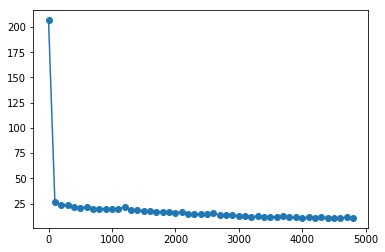

Iter: 4900
Loss: 10.28
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.87773132  10.708498    11.38479137  10.74891663  10.2765913 ]


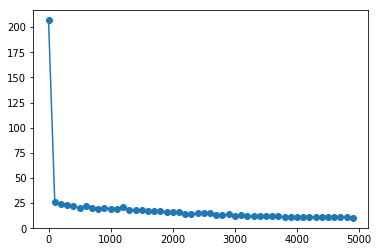

Iter: 5000
Loss: 11.29
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.87773132  10.708498    11.38479137  10.74891663  10.2765913
  11.29227

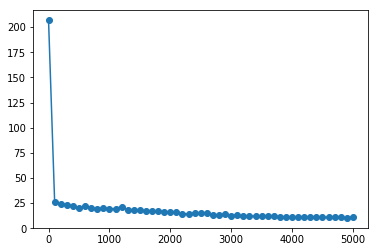

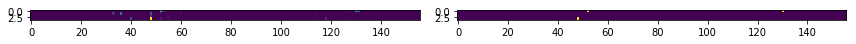

Iter: 5100
Loss: 10.53
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.87773132  10.708498    11.38479137  10.74891663  10.2765913
  11

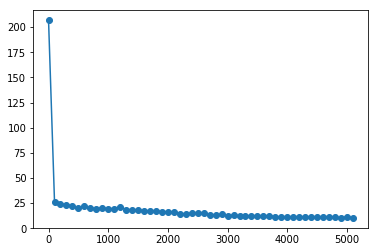

Iter: 5200
Loss: 10.73
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.87773132  10.708498    11.38479137  10.74891663  10.276591

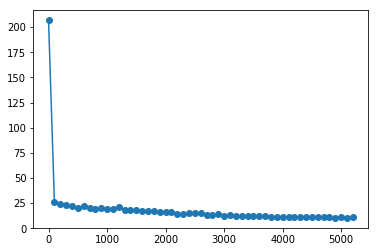

Iter: 5300
Loss: 10.61
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.87773132  10.708498    11.38479137  10.74891663  10.

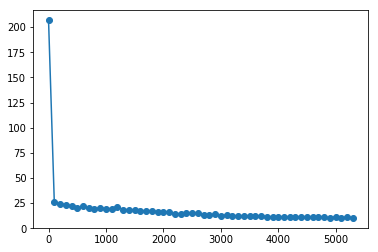

Iter: 5400
Loss: 11.41
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.87773132  10.708498    11.38479137  10.7489166

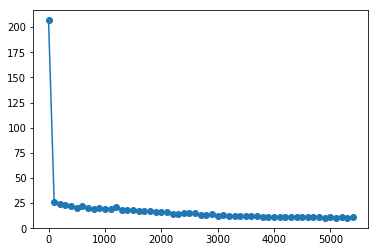

Iter: 5500
Loss: 10.29
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.87773132  10.708498    11.38479137  10.7

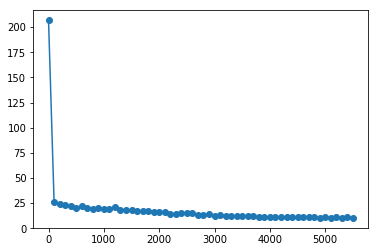

Iter: 5600
Loss: 11.21
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.87773132  10.708498    11.38479137

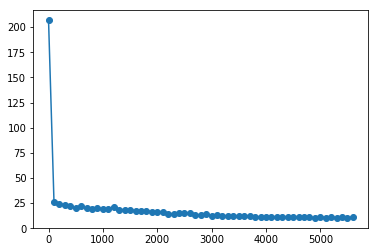

Iter: 5700
Loss: 10.7
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.87773132  10.708498    11.384

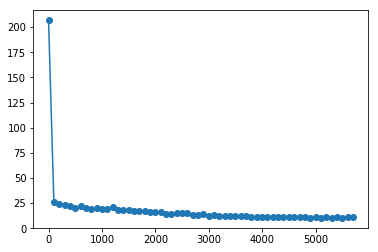

Iter: 5800
Loss: 10.44
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.87773132  10.708498   

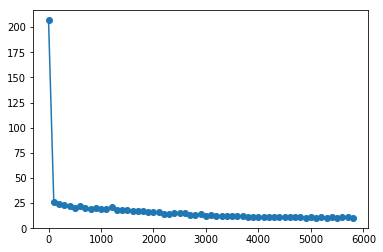

Iter: 5900
Loss: 11.13
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.87773132  10.708

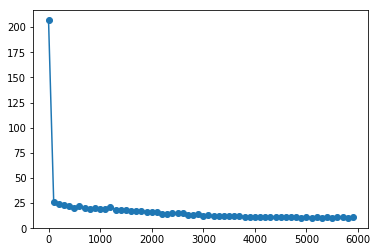

Iter: 6000
Loss: 9.914
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.87773132 

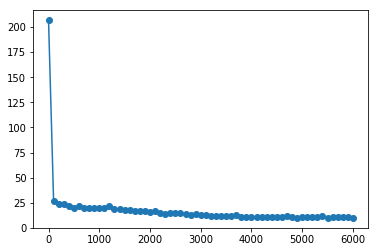

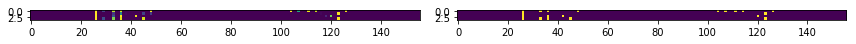

Iter: 6100
Loss: 10.62
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  10.877

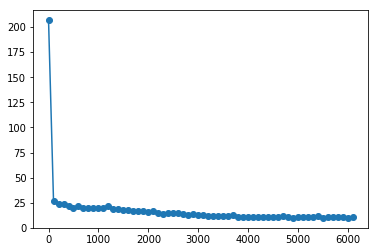

Iter: 6200
Loss: 10.55
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839367
  

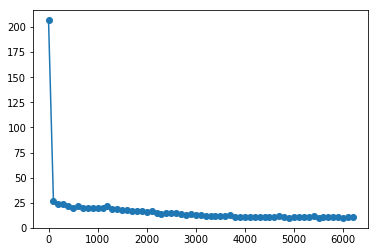

Iter: 6300
Loss: 9.983
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11.10839

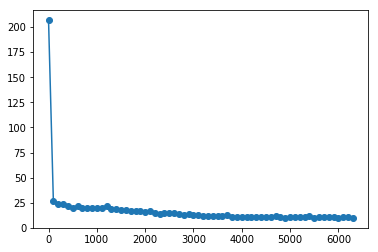

Iter: 6400
Loss: 10.58
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.19720173  11

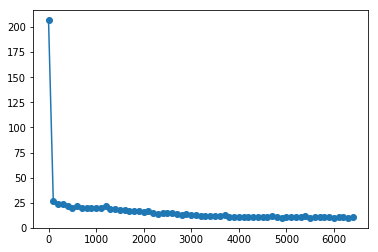

Iter: 6500
Loss: 10.16
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.197201

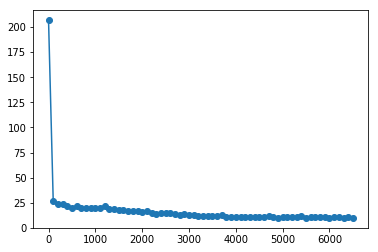

Iter: 6600
Loss: 10.17
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.90377808  11.

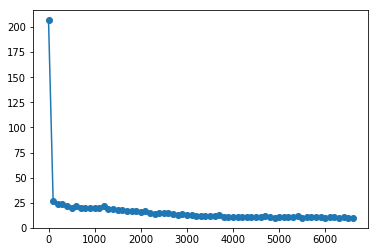

Iter: 6700
Loss: 10.35
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.9037780

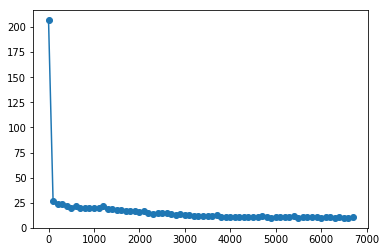

Iter: 6800
Loss: 10.63
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357  10.9

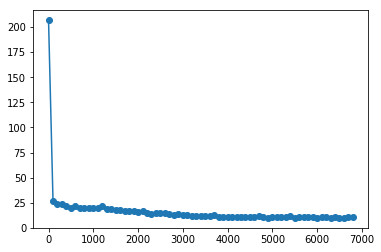

Iter: 6900
Loss: 10.04
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16169357

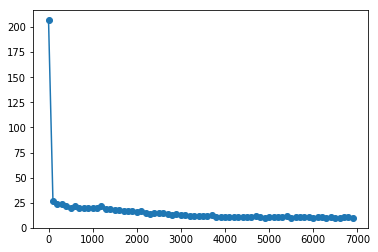

Iter: 7000
Loss: 10.61
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  11.16

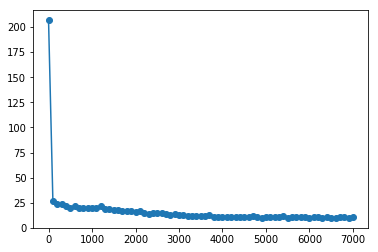

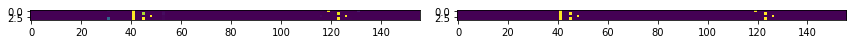

Iter: 7100
Loss: 11.4
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89647102  

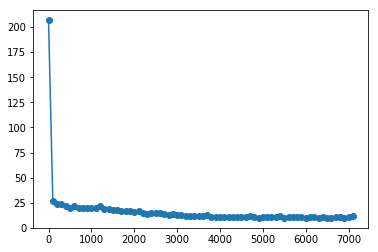

Iter: 7200
Loss: 11.09
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
  10.89

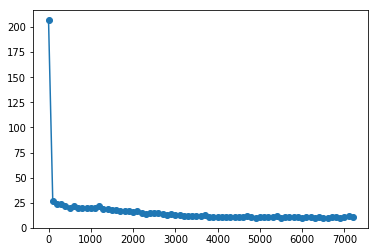

Iter: 7300
Loss: 9.873
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.22249603
 

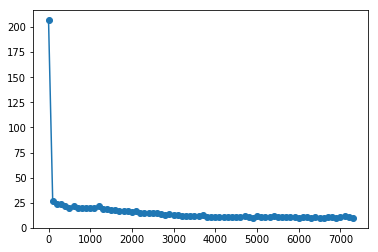

Iter: 7400
Loss: 9.848
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  11.2224

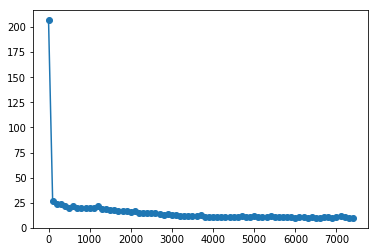

Iter: 7500
Loss: 10.32
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605354  1

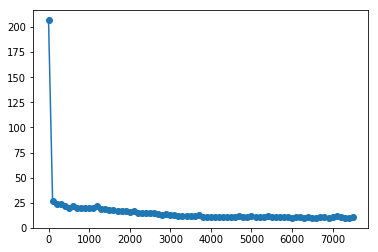

Iter: 7600
Loss: 10.24
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11.15605

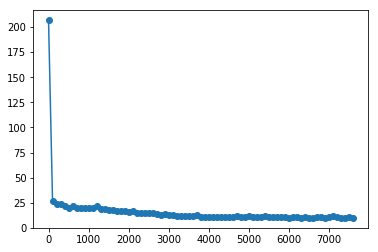

Iter: 7700
Loss: 11.02
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.50840187  11

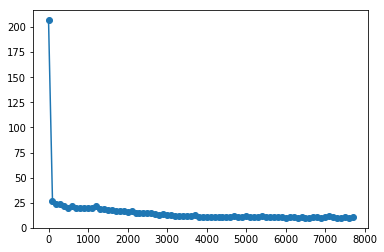

Iter: 7800
Loss: 10.75
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.508401

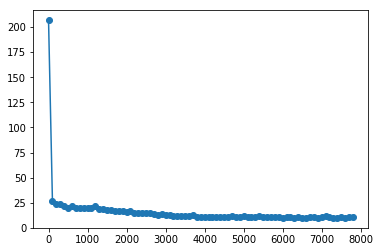

Iter: 7900
Loss: 9.732
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90377331  12.

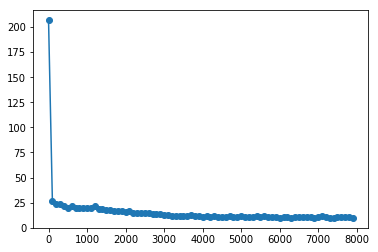

Iter: 8000
Loss: 10.72
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.9037733

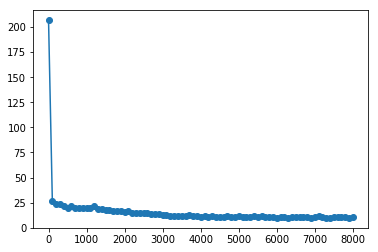

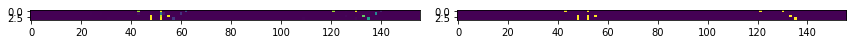

Iter: 8100
Loss: 10.2
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569  11.90

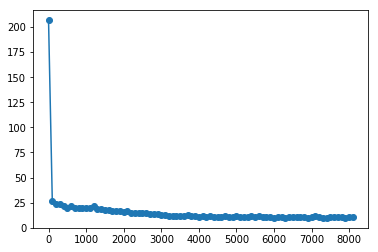

Iter: 8200
Loss: 10.08
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77034569

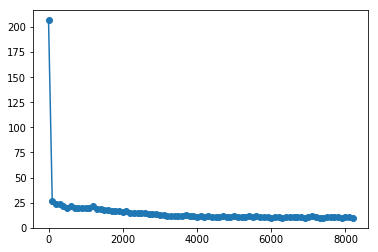

Iter: 8300
Loss: 9.899
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
  11.77

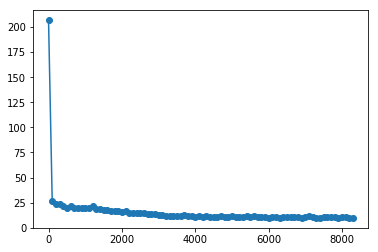

Iter: 8400
Loss: 9.93
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.
 8400.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.8769865
 

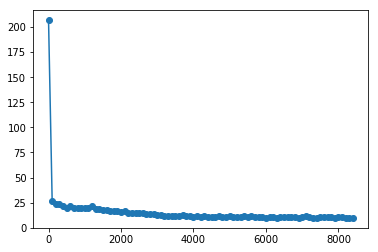

Iter: 8500
Loss: 10.39
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.
 8400. 8500.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215  11.87

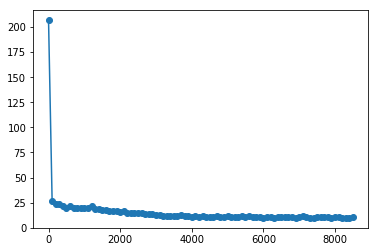

Iter: 8600
Loss: 10.02
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.
 8400. 8500. 8600.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.13852215 

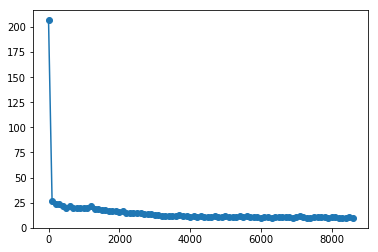

Iter: 8700
Loss: 9.714
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.
 8400. 8500. 8600. 8700.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  12.138

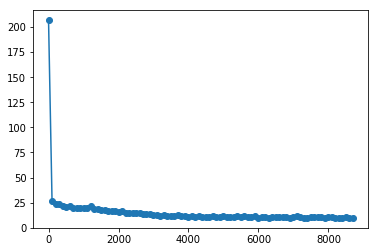

Iter: 8800
Loss: 9.765
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.
 8400. 8500. 8600. 8700. 8800.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.84225273  

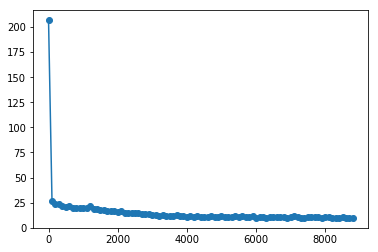

Iter: 8900
Loss: 10.19
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.
 8400. 8500. 8600. 8700. 8800. 8900.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  11.8422

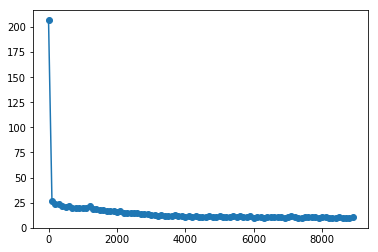

Iter: 9000
Loss: 10.92
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.
 8400. 8500. 8600. 8700. 8800. 8900. 9000.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475613  1

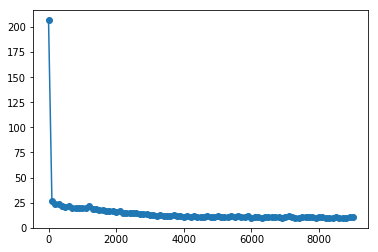

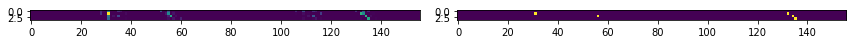

Iter: 9100
Loss: 10.14
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.
 8400. 8500. 8600. 8700. 8800. 8900. 9000. 9100.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.84475

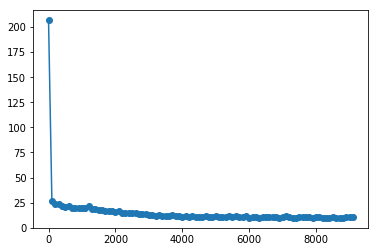

Iter: 9200
Loss: 10.5
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.
 8400. 8500. 8600. 8700. 8800. 8900. 9000. 9100. 9200.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.66326141  12.

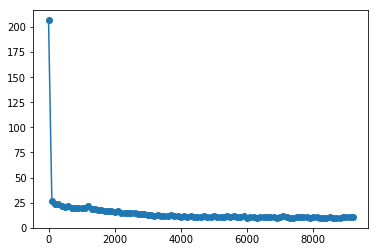

Iter: 9300
Loss: 10.41
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.
 8400. 8500. 8600. 8700. 8800. 8900. 9000. 9100. 9200. 9300.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.663261

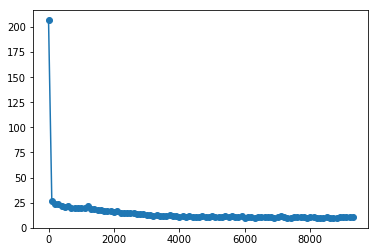

Iter: 9400
Loss: 10.02
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.
 8400. 8500. 8600. 8700. 8800. 8900. 9000. 9100. 9200. 9300. 9400.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933
  12.

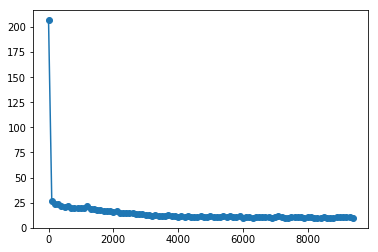

Iter: 9500
Loss: 10.18
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.
 8400. 8500. 8600. 8700. 8800. 8900. 9000. 9100. 9200. 9300. 9400. 9500.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.7864933

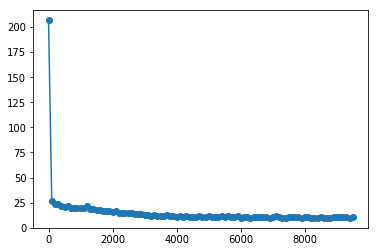

Iter: 9600
Loss: 10.01
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.
 8400. 8500. 8600. 8700. 8800. 8900. 9000. 9100. 9200. 9300. 9400. 9500.
 9600.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.14471626  13.

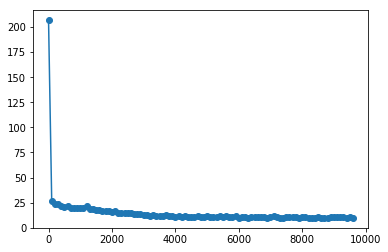

Iter: 9700
Loss: 10.49
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.
 8400. 8500. 8600. 8700. 8800. 8900. 9000. 9100. 9200. 9300. 9400. 9500.
 9600. 9700.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.1447162

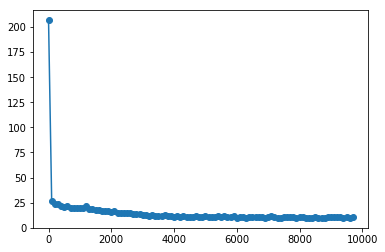

Iter: 9800
Loss: 10.04
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.
 8400. 8500. 8600. 8700. 8800. 8900. 9000. 9100. 9200. 9300. 9400. 9500.
 9600. 9700. 9800.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938  13.1

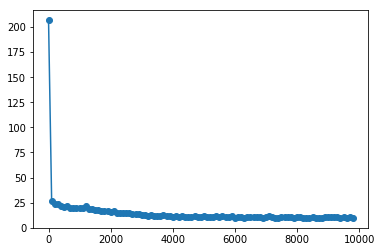

Iter: 9900
Loss: 9.784
[   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000. 2100. 2200. 2300.
 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200. 3300. 3400. 3500.
 3600. 3700. 3800. 3900. 4000. 4100. 4200. 4300. 4400. 4500. 4600. 4700.
 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500. 5600. 5700. 5800. 5900.
 6000. 6100. 6200. 6300. 6400. 6500. 6600. 6700. 6800. 6900. 7000. 7100.
 7200. 7300. 7400. 7500. 7600. 7700. 7800. 7900. 8000. 8100. 8200. 8300.
 8400. 8500. 8600. 8700. 8800. 8900. 9000. 9100. 9200. 9300. 9400. 9500.
 9600. 9700. 9800. 9900.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.5450592
  16.02667046  16.5205307   14.62726593  14.29292202  14.9766407
  14.87057018  15.10950851  13.36681938

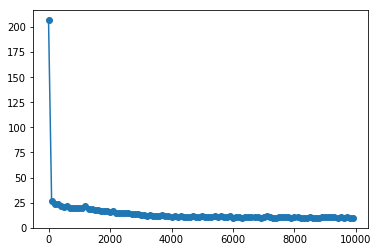

Iter: 10000
Loss: 9.921
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064  16.54

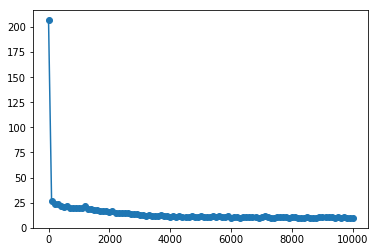

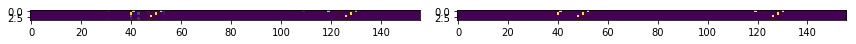

Iter: 10100
Loss: 9.952
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.04647064

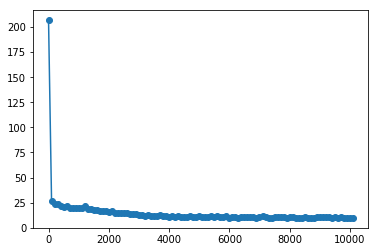

Iter: 10200
Loss: 11.15
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149   17.0

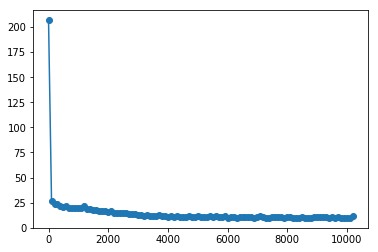

Iter: 10300
Loss: 9.861
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.0208149

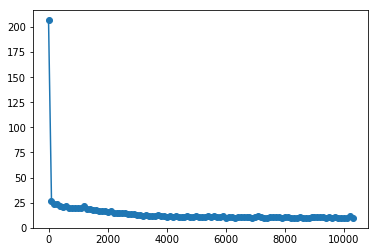

Iter: 10400
Loss: 9.447
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.48999405  17.

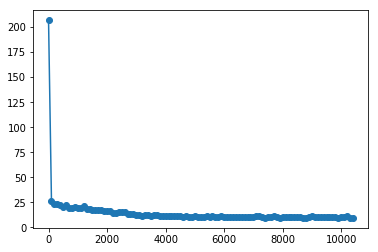

Iter: 10500
Loss: 10.11
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17.489994

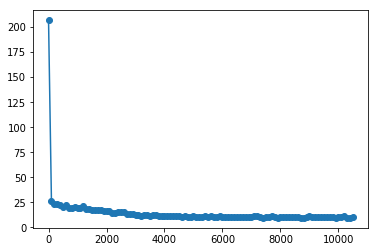

Iter: 10600
Loss: 10.37
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480919  17

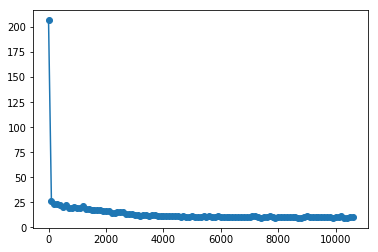

Iter: 10700
Loss: 11.25
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  17.70480

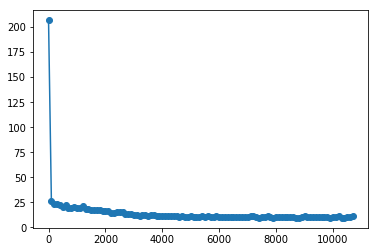

Iter: 10800
Loss: 9.874
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518303
  1

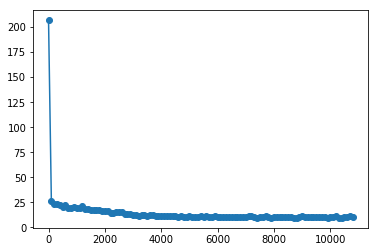

Iter: 10900
Loss: 9.708
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  18.45518

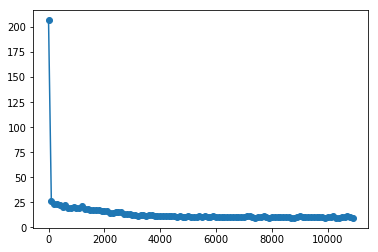

Iter: 11000
Loss: 9.962
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.57717896  

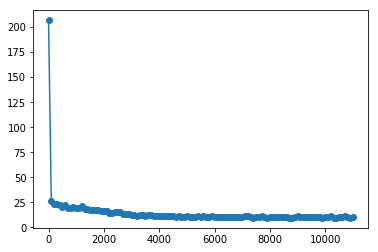

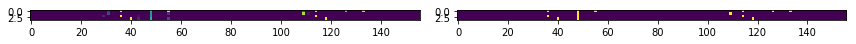

Iter: 11100
Loss: 10.04
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073  18.577

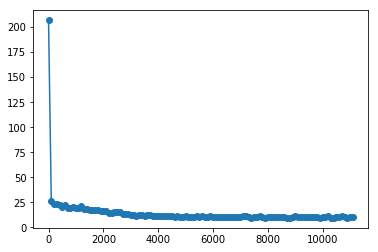

Iter: 11200
Loss: 10.19
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58200073 

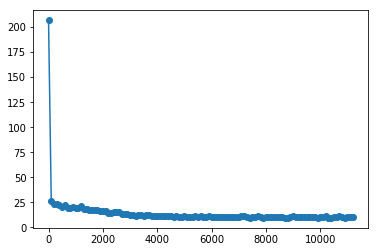

Iter: 11300
Loss: 9.868
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991  21.58

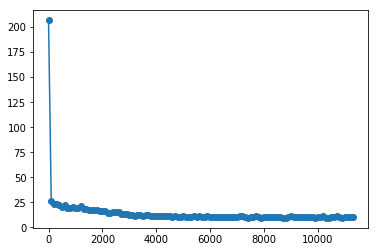

Iter: 11400
Loss: 9.777
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.49044991

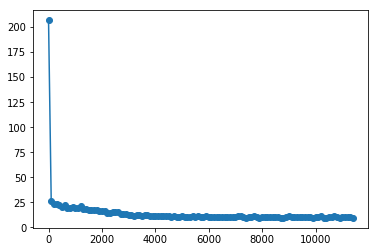

Iter: 11500
Loss: 10.31
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.51522064  19.4

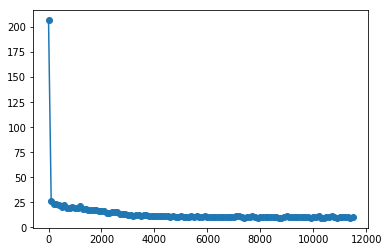

Iter: 11600
Loss: 9.386
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.5152206

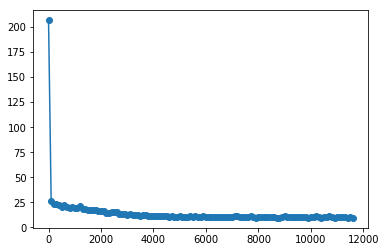

Iter: 11700
Loss: 10.74
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.93855095
  19.

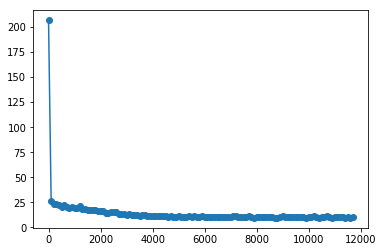

Iter: 11800
Loss: 11.21
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.9385509

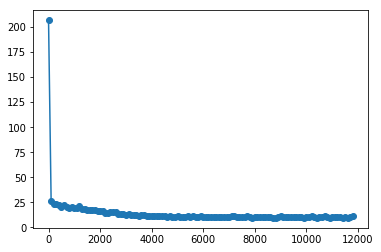

Iter: 11900
Loss: 10.26
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378792  19.

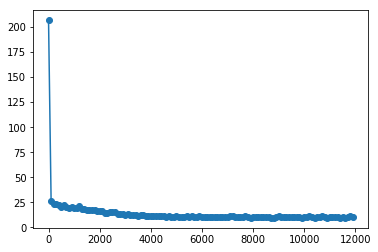

Iter: 12000
Loss: 9.812
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  19.58378

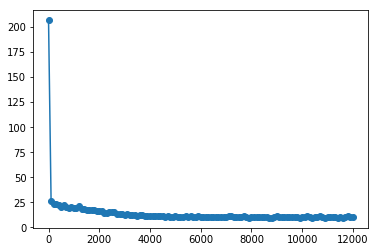

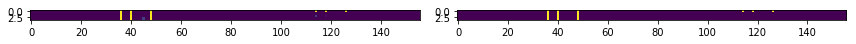

Iter: 12100
Loss: 10.54
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.79444504  1

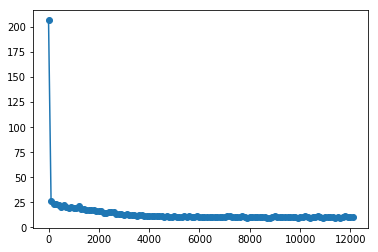

Iter: 12200
Loss: 10.09
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  19.7944

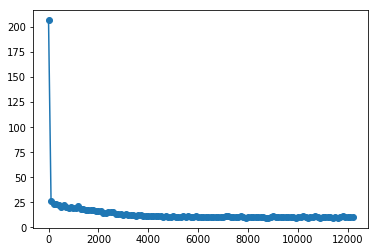

Iter: 12300
Loss: 9.927
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.92355919  

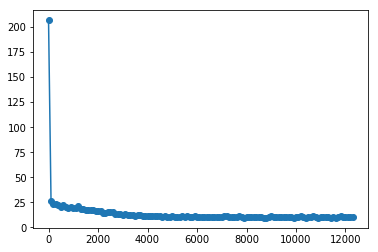

Iter: 12400
Loss: 10.22
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  21.923

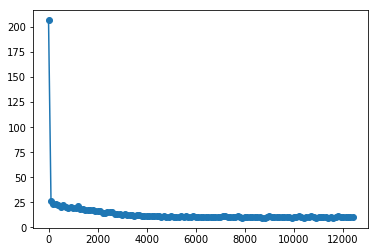

Iter: 12500
Loss: 9.94
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.11178589  

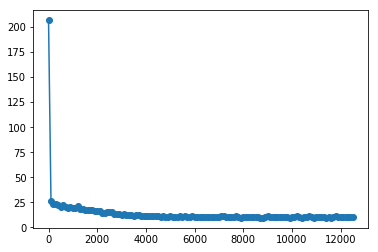

Iter: 12600
Loss: 10.3
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015
  20.111

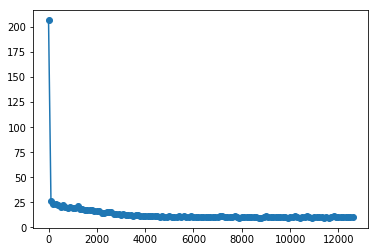

Iter: 12700
Loss: 9.727
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86528015


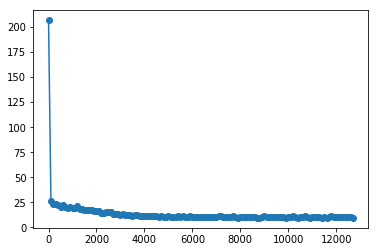

Iter: 12800
Loss: 10.32
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800.]
[206.77296448  26.47010231  23.75245667  23.58371162  21.86

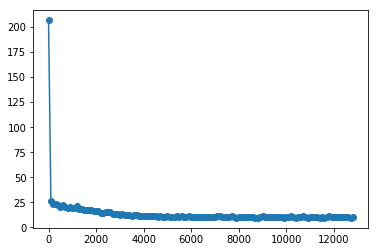

Iter: 12900
Loss: 10.38
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.]
[206.77296448  26.47010231  23.75245667  23.58371162

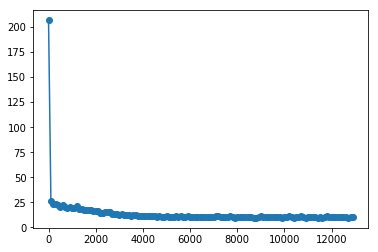

Iter: 13000
Loss: 9.93
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000.]
[206.77296448  26.47010231  23.75245667  23.5

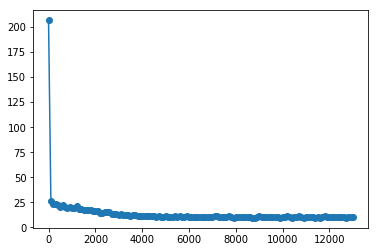

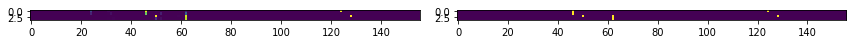

Iter: 13100
Loss: 9.439
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100.]
[206.77296448  26.47010231  23.752456

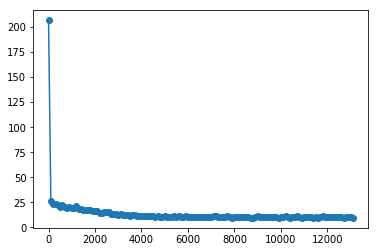

Iter: 13200
Loss: 10.15
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200.]
[206.77296448  26.47010231  23

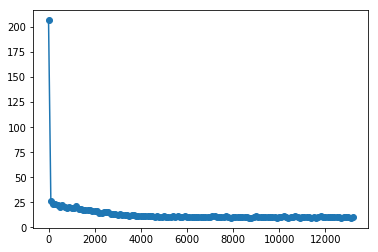

Iter: 13300
Loss: 9.988
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300.]
[206.77296448  26.47010

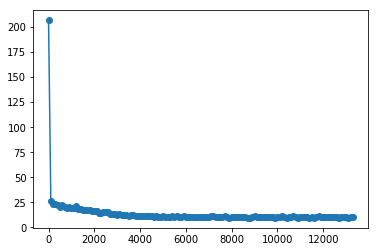

Iter: 13400
Loss: 9.952
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400.]
[206.77296448  2

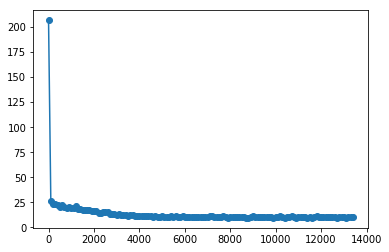

Iter: 13500
Loss: 11.23
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500.]
[206.7729

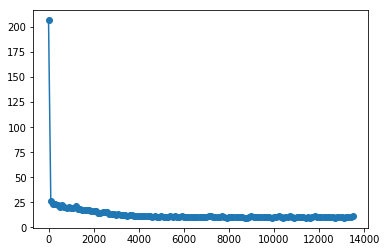

Iter: 13600
Loss: 10.19
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600.]
[2

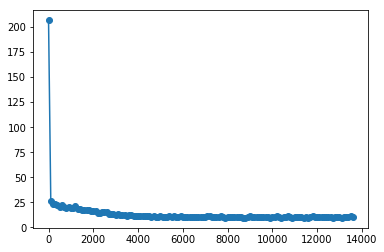

Iter: 13700
Loss: 9.846
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

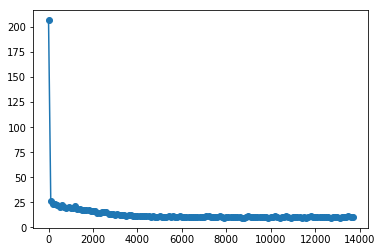

Iter: 13800
Loss: 10.28
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

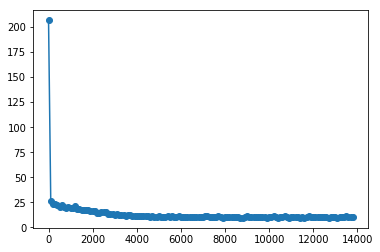

Iter: 13900
Loss: 9.928
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

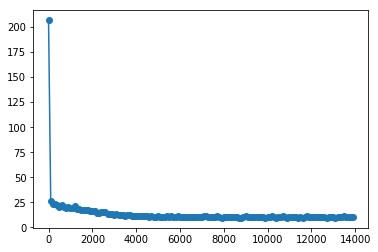

Iter: 14000
Loss: 9.362
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

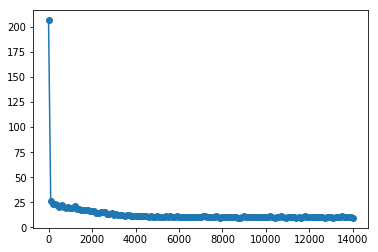

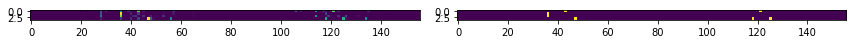

Iter: 14100
Loss: 9.815
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

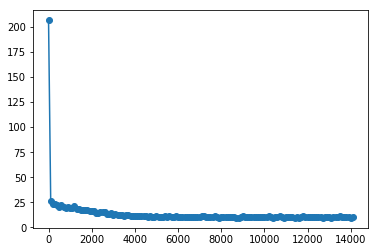

Iter: 14200
Loss: 9.407
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

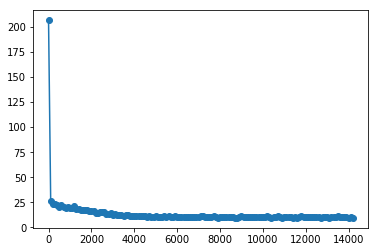

Iter: 14300
Loss: 9.743
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

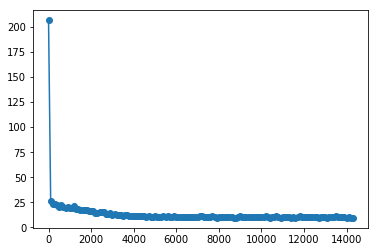

Iter: 14400
Loss: 9.711
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

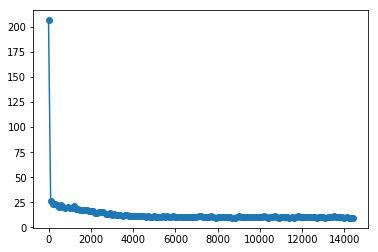

Iter: 14500
Loss: 9.706
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

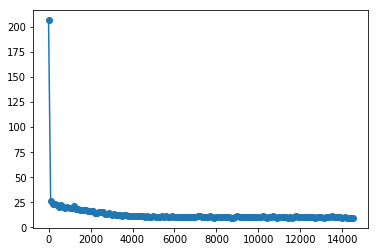

Iter: 14600
Loss: 9.779
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

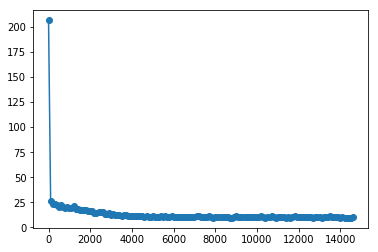

Iter: 14700
Loss: 10.52
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

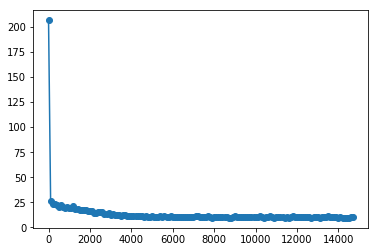

Iter: 14800
Loss: 10.3
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 1370

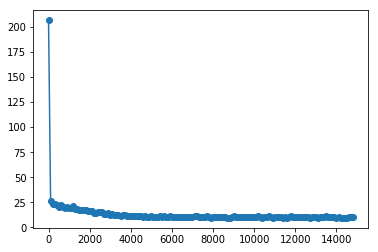

Iter: 14900
Loss: 9.896
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

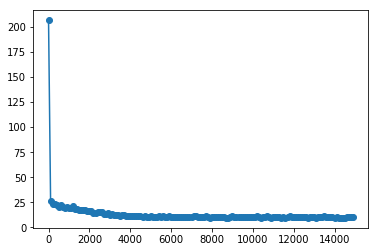

Iter: 15000
Loss: 10.16
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

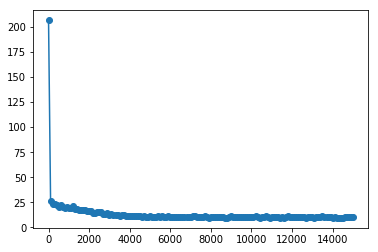

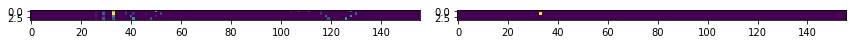

Iter: 15100
Loss: 10.18
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

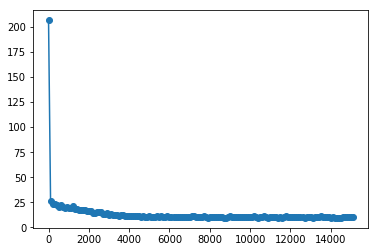

Iter: 15200
Loss: 10.85
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

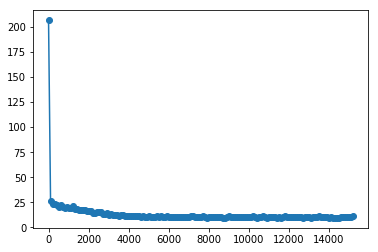

Iter: 15300
Loss: 10.03
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

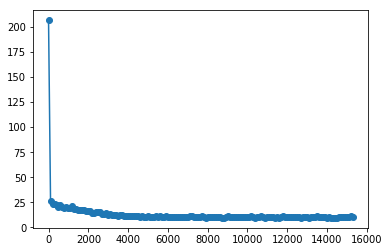

Iter: 15400
Loss: 9.605
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

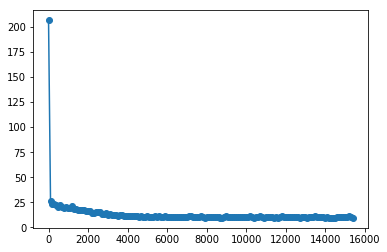

Iter: 15500
Loss: 10.13
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

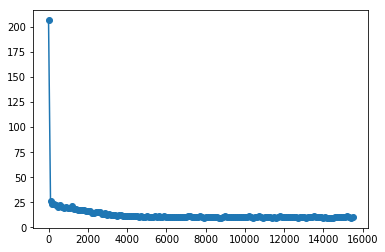

Iter: 15600
Loss: 10.11
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

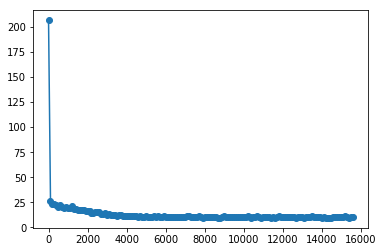

Iter: 15700
Loss: 10.46
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

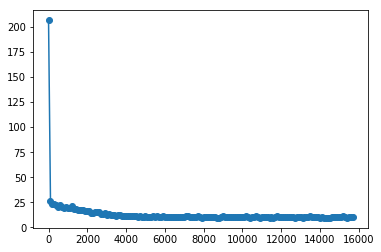

Iter: 15800
Loss: 10.09
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

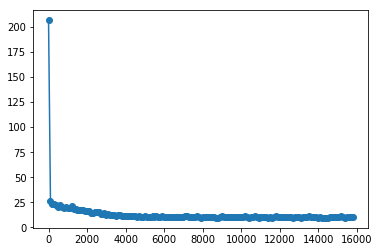

Iter: 15900
Loss: 9.689
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

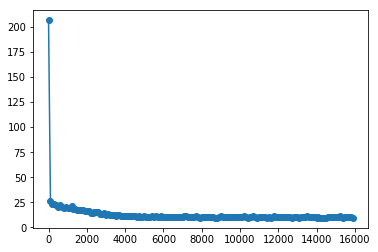

Iter: 16000
Loss: 10.27
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

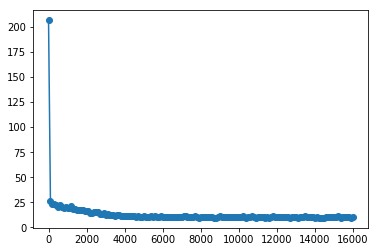

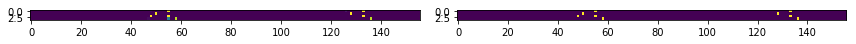

Iter: 16100
Loss: 9.96
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 1370

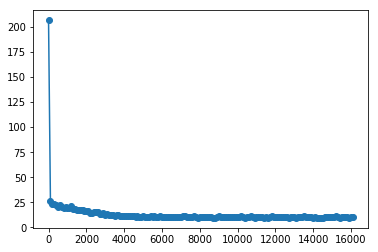

Iter: 16200
Loss: 10.35
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

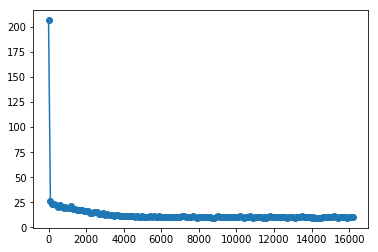

Iter: 16300
Loss: 10.28
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

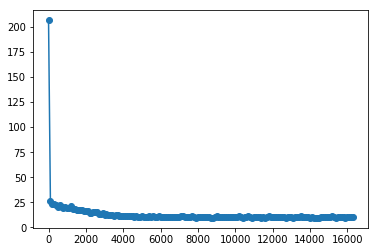

Iter: 16400
Loss: 10.22
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

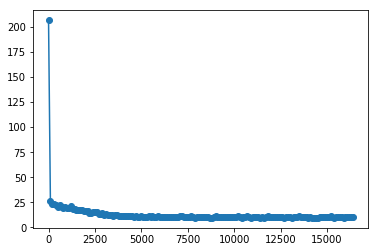

Iter: 16500
Loss: 10.84
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

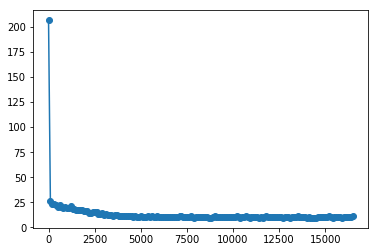

Iter: 16600
Loss: 11.41
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

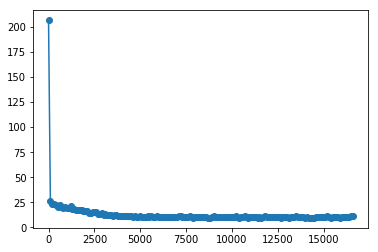

Iter: 16700
Loss: 10.64
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

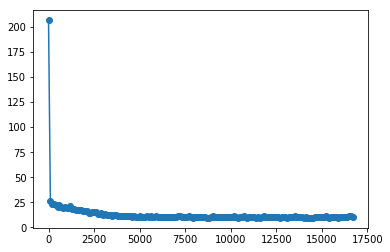

Iter: 16800
Loss: 9.7
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 13700

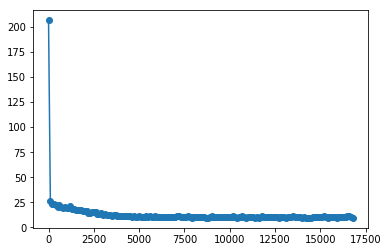

Iter: 16900
Loss: 9.976
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

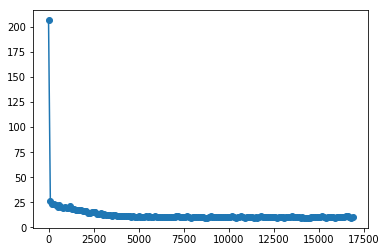

Iter: 17000
Loss: 9.672
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

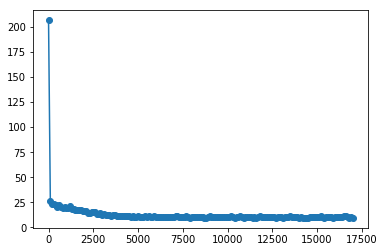

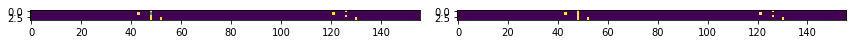

Iter: 17100
Loss: 10.65
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

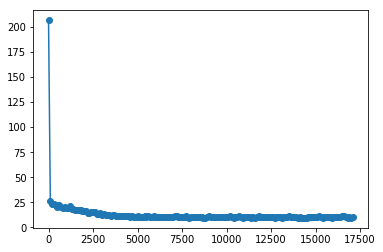

Iter: 17200
Loss: 9.59
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 1370

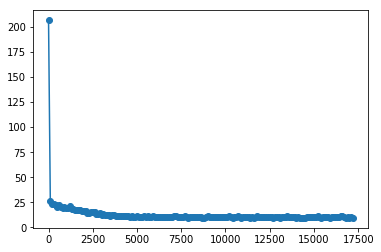

Iter: 17300
Loss: 9.643
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

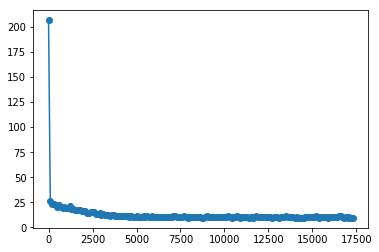

Iter: 17400
Loss: 9.794
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

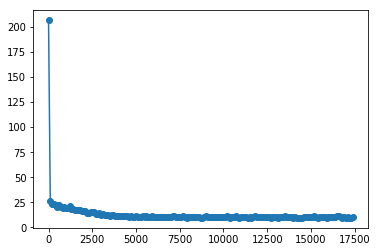

Iter: 17500
Loss: 10.48
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

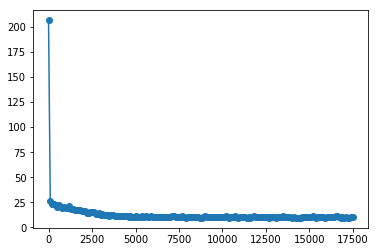

Iter: 17600
Loss: 9.783
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

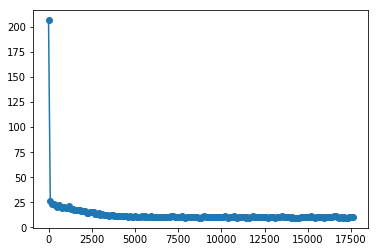

Iter: 17700
Loss: 10.27
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

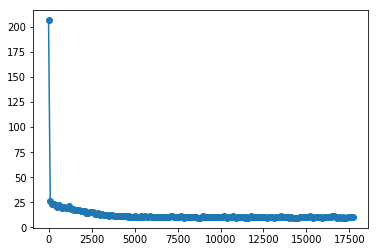

Iter: 17800
Loss: 11.64
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

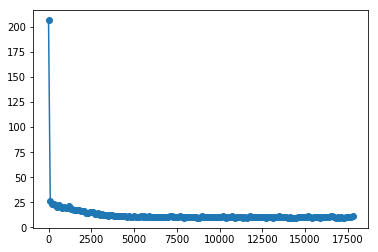

Iter: 17900
Loss: 10.29
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

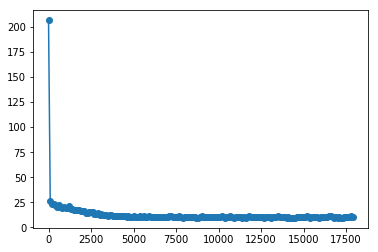

Iter: 18000
Loss: 9.161
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

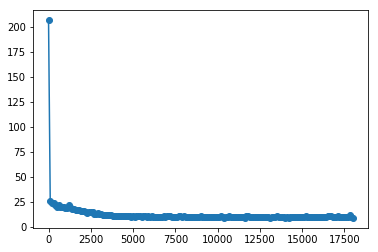

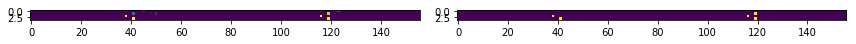

Iter: 18100
Loss: 9.396
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

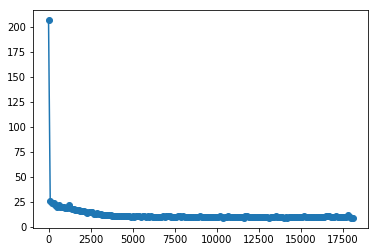

Iter: 18200
Loss: 9.593
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

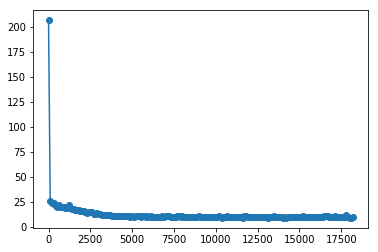

Iter: 18300
Loss: 10.53
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

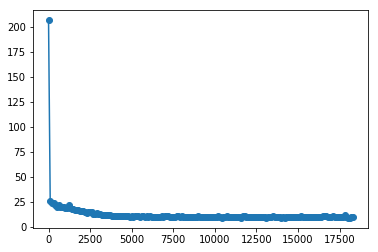

Iter: 18400
Loss: 10.45
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

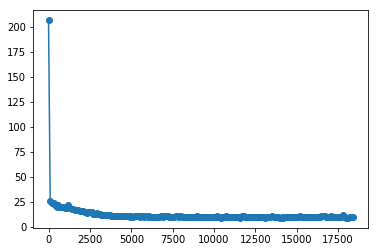

Iter: 18500
Loss: 9.883
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

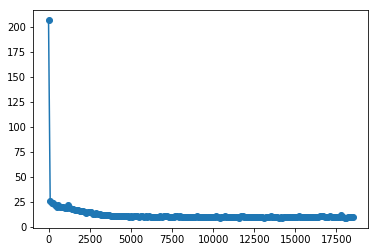

Iter: 18600
Loss: 10.62
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

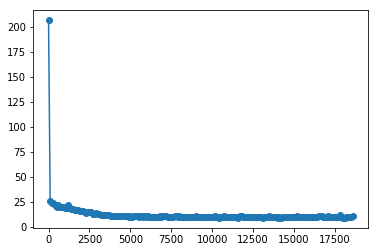

Iter: 18700
Loss: 9.738
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

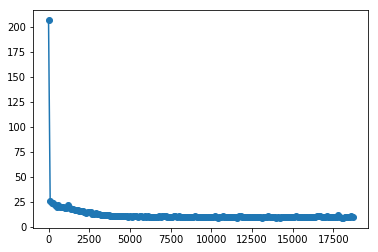

Iter: 18800
Loss: 9.525
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

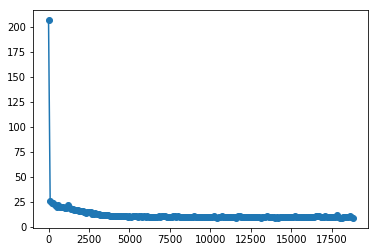

Iter: 18900
Loss: 9.808
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

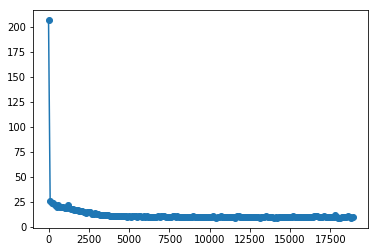

Iter: 19000
Loss: 10.43
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

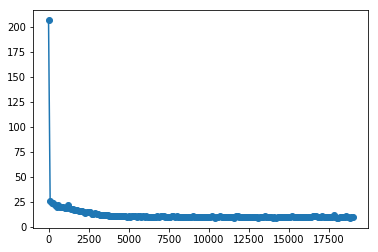

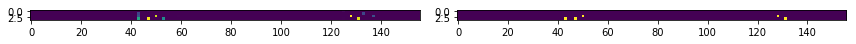

Iter: 19100
Loss: 9.698
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

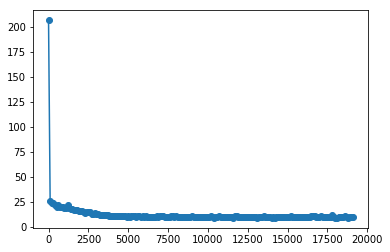

Iter: 19200
Loss: 9.234
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

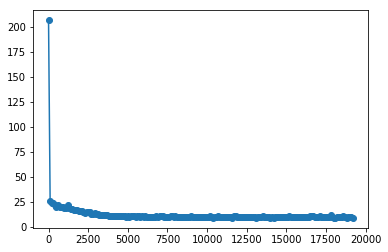

Iter: 19300
Loss: 9.834
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

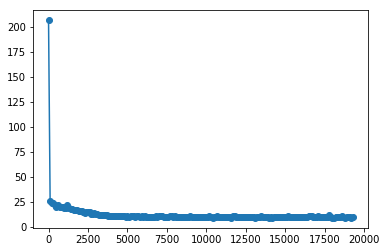

Iter: 19400
Loss: 10.14
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

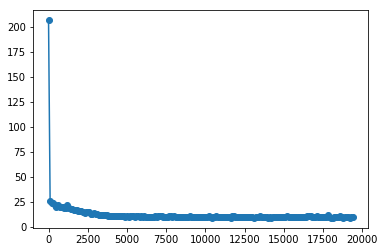

Iter: 19500
Loss: 9.812
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

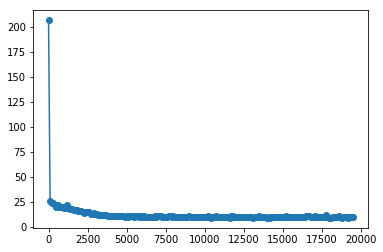

Iter: 19600
Loss: 9.703
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

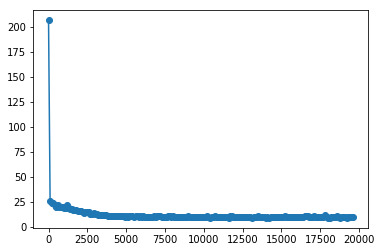

Iter: 19700
Loss: 9.897
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

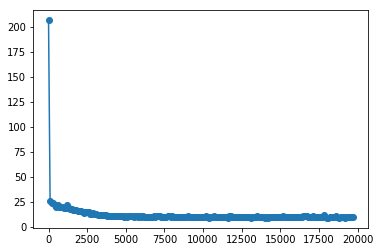

Iter: 19800
Loss: 9.665
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

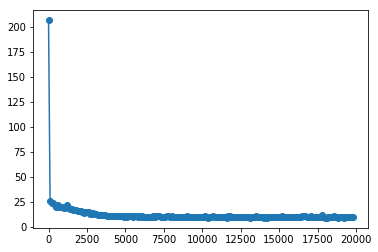

Iter: 19900
Loss: 9.688
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

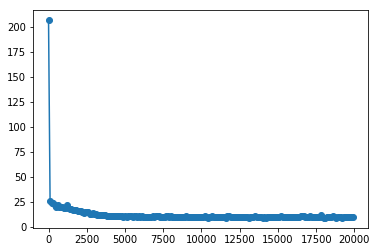

Iter: 20000
Loss: 10.01
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

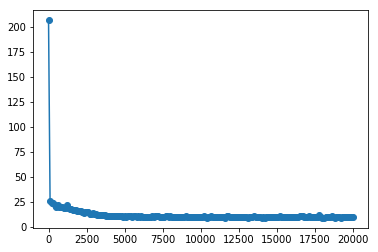

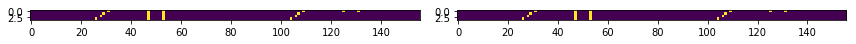

Iter: 20100
Loss: 9.68
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 1370

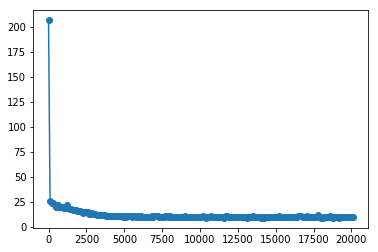

Iter: 20200
Loss: 9.2
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 13700

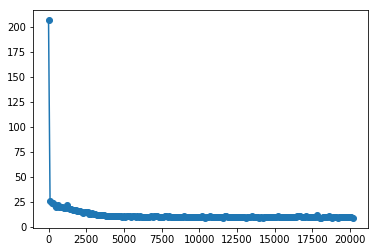

Iter: 20300
Loss: 10.31
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

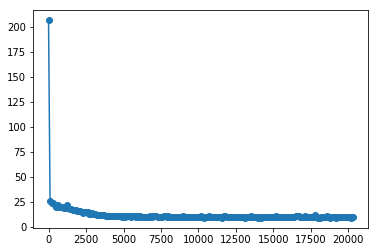

Iter: 20400
Loss: 9.975
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

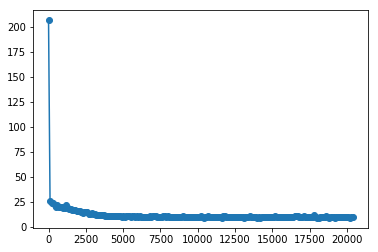

Iter: 20500
Loss: 10.08
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

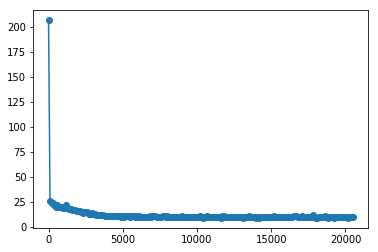

Iter: 20600
Loss: 10.29
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

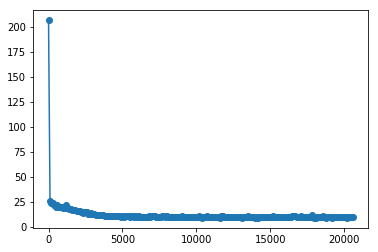

Iter: 20700
Loss: 9.442
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

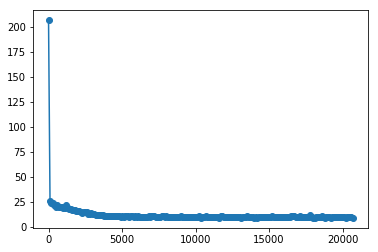

Iter: 20800
Loss: 9.293
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

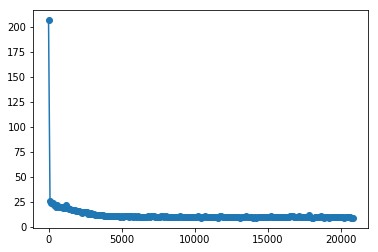

Iter: 20900
Loss: 9.657
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

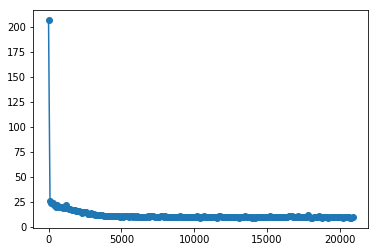

Iter: 21000
Loss: 9.144
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

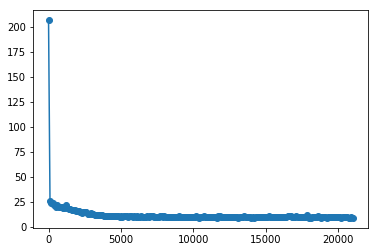

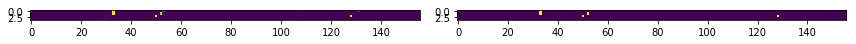

Iter: 21100
Loss: 9.8
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 13700

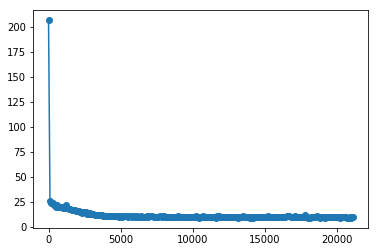

Iter: 21200
Loss: 9.976
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

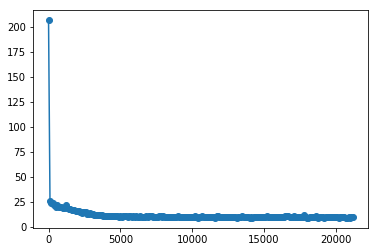

Iter: 21300
Loss: 9.372
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

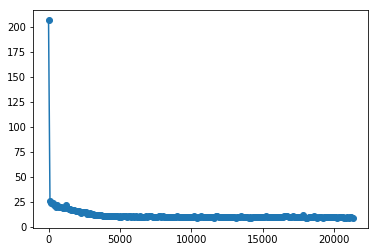

Iter: 21400
Loss: 9.466
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

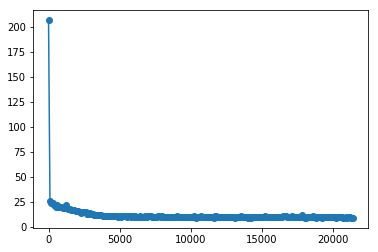

Iter: 21500
Loss: 9.802
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

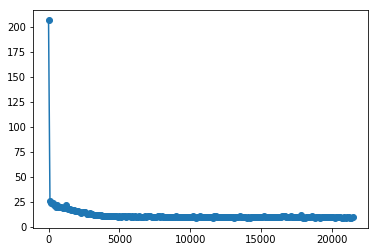

Iter: 21600
Loss: 9.726
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

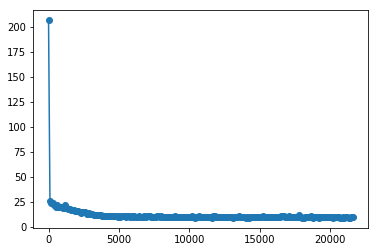

Iter: 21700
Loss: 9.4
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 13700

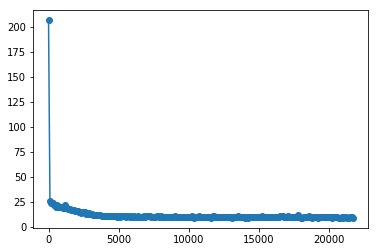

Iter: 21800
Loss: 9.729
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

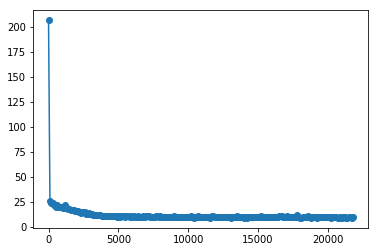

Iter: 21900
Loss: 9.639
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

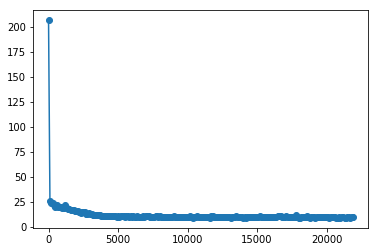

Iter: 22000
Loss: 9.832
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

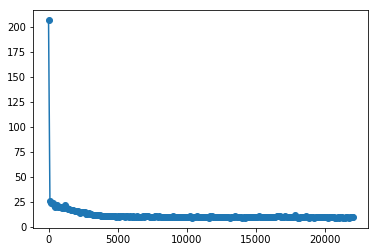

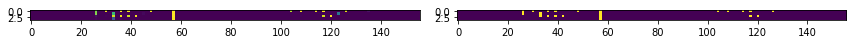

Iter: 22100
Loss: 9.778
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

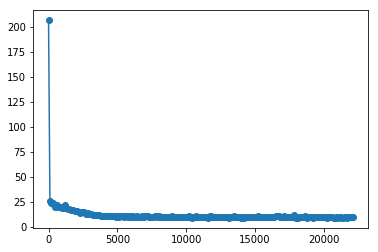

Iter: 22200
Loss: 9.454
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

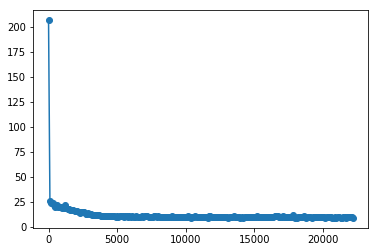

Iter: 22300
Loss: 9.682
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

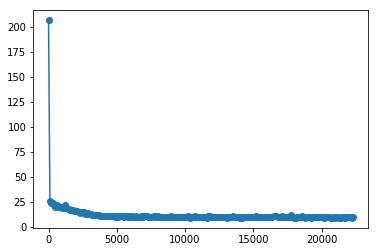

Iter: 22400
Loss: 9.712
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

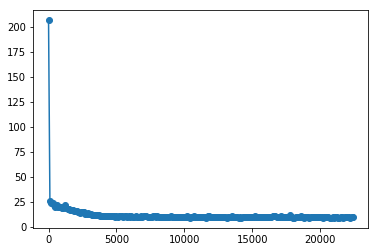

Iter: 22500
Loss: 9.585
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

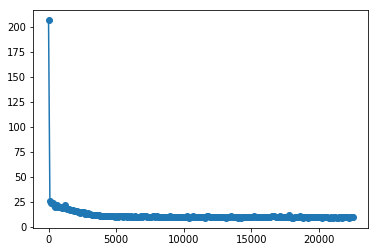

Iter: 22600
Loss: 10.08
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

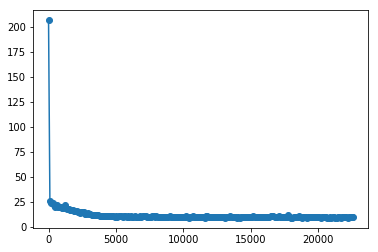

Iter: 22700
Loss: 10.32
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

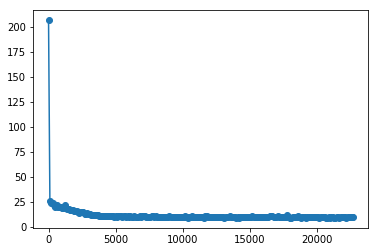

Iter: 22800
Loss: 9.879
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

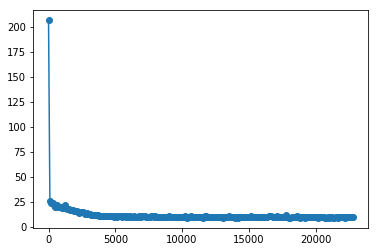

Iter: 22900
Loss: 9.885
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

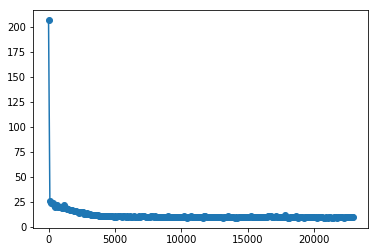

Iter: 23000
Loss: 9.515
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

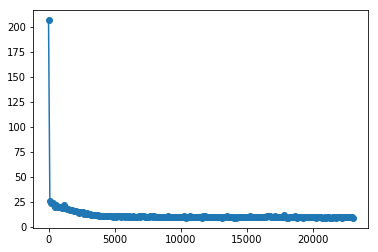

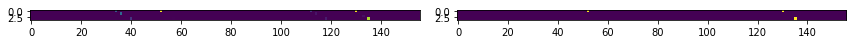

Iter: 23100
Loss: 9.378
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

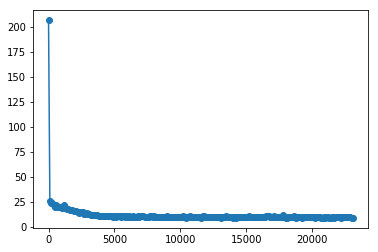

Iter: 23200
Loss: 9.683
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

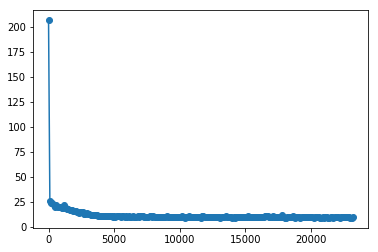

Iter: 23300
Loss: 9.719
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

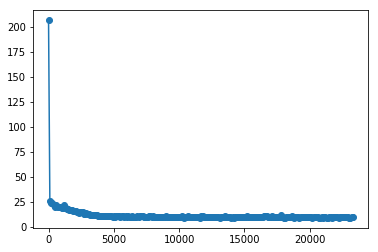

Iter: 23400
Loss: 9.186
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

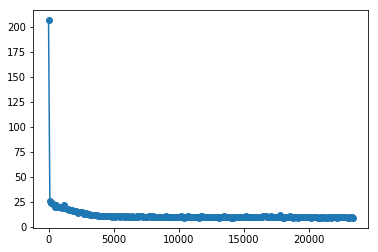

Iter: 23500
Loss: 9.762
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

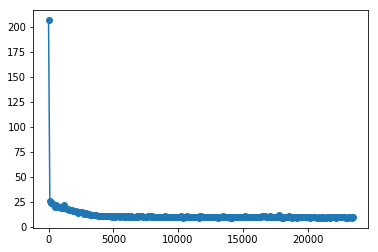

Iter: 23600
Loss: 9.421
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

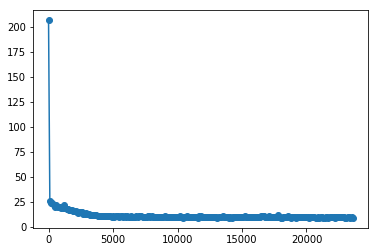

Iter: 23700
Loss: 9.778
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

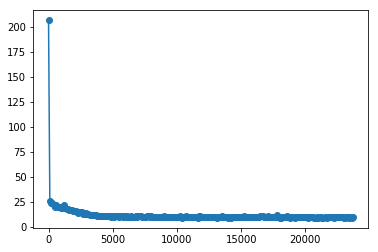

Iter: 23800
Loss: 9.802
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

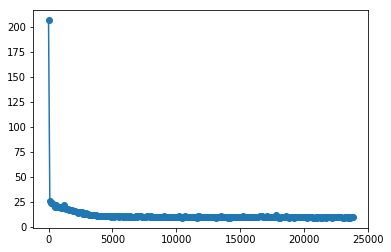

Iter: 23900
Loss: 9.178
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

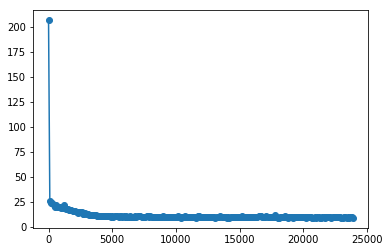

Iter: 24000
Loss: 9.707
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

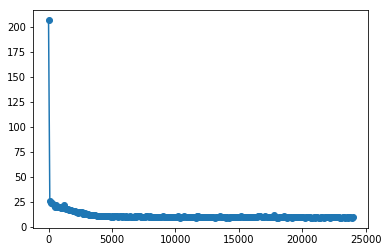

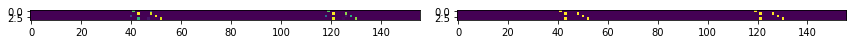

Iter: 24100
Loss: 9.116
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

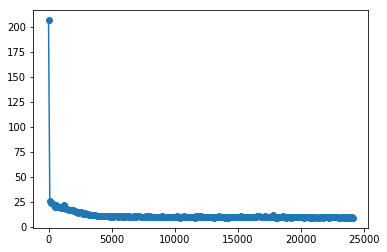

Iter: 24200
Loss: 9.367
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

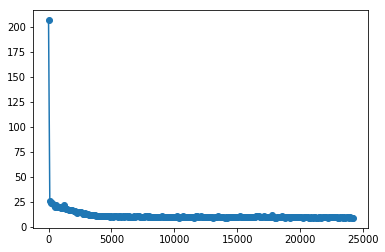

Iter: 24300
Loss: 9.735
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

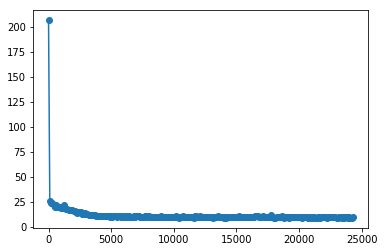

Iter: 24400
Loss: 9.862
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

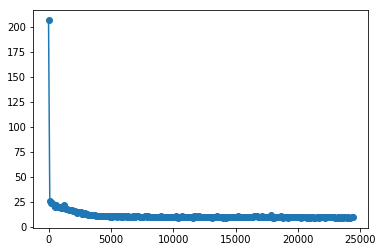

Iter: 24500
Loss: 9.82
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 1370

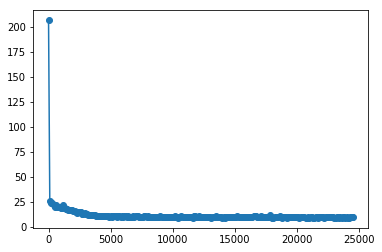

Iter: 24600
Loss: 9.479
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

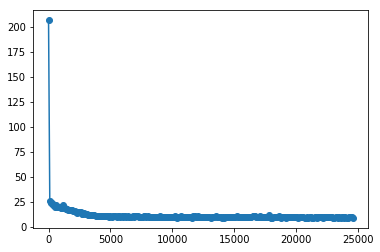

Iter: 24700
Loss: 10.77
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

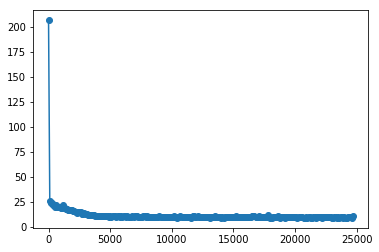

Iter: 24800
Loss: 9.271
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

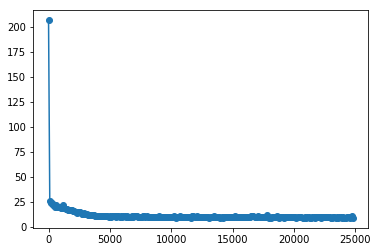

Iter: 24900
Loss: 9.42
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 1370

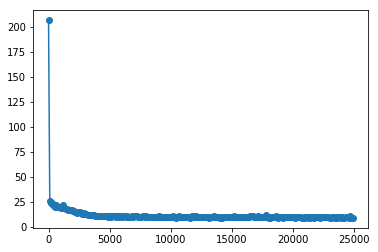

Iter: 25000
Loss: 9.117
[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
  3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
  4000.  4100.  4200.  4300.  4400.  4500.  4600.  4700.  4800.  4900.
  5000.  5100.  5200.  5300.  5400.  5500.  5600.  5700.  5800.  5900.
  6000.  6100.  6200.  6300.  6400.  6500.  6600.  6700.  6800.  6900.
  7000.  7100.  7200.  7300.  7400.  7500.  7600.  7700.  7800.  7900.
  8000.  8100.  8200.  8300.  8400.  8500.  8600.  8700.  8800.  8900.
  9000.  9100.  9200.  9300.  9400.  9500.  9600.  9700.  9800.  9900.
 10000. 10100. 10200. 10300. 10400. 10500. 10600. 10700. 10800. 10900.
 11000. 11100. 11200. 11300. 11400. 11500. 11600. 11700. 11800. 11900.
 12000. 12100. 12200. 12300. 12400. 12500. 12600. 12700. 12800. 12900.
 13000. 13100. 13200. 13300. 13400. 13500. 13600. 137

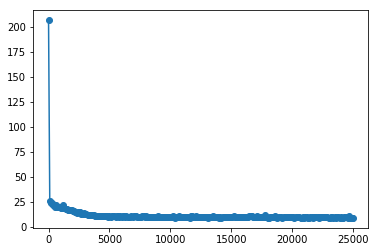

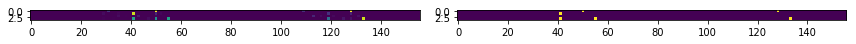

In [ ]:
num_epochs = 25000 #The number of training epochs that we are going to run. For each epoch we go through the entire data set.
batch_size = 100 #The number of training examples that we are going to send through the model at a time. 
# lr         = tf.constant(0.005, tf.float32) #The learning rate of our model

i = 0
loss_value = np.array([])
iter_value = np.array([])
songs = [songs[0]]
while i <= num_epochs:
    for song in songs:
        # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
        # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements
        song = np.array(song)
        song = song[:np.floor(song.shape[0]/num_timesteps).astype(int)*num_timesteps]
        song = np.reshape(song, [int(song.shape[0]/num_timesteps), song.shape[1]*num_timesteps])
        
        # Train the VAE on batch_size examples at a time
        for ind in range(0, len(song), batch_size): 
            X_mb = song[ind:ind+batch_size]
            _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})
            
        
        
        

    
    if i % 100 == 0:
        print('Iter: {}'.format(i))
        print('Loss: {:.4}'. format(loss))
        iter_value = np.append(iter_value, i)
            
        loss_value = np.append(loss_value, loss)

        print(iter_value)
        print(loss_value)
        plt.figure()
 
        
    if i % 1000 == 0:
        samples = sess.run(X_samples, feed_dict={z: np.random.randn(1,z_dim)})
        S = np.reshape(samples, (num_timesteps, 2*note_range))
        thresh_S = S>=0.5
        plt.figure(figsize=(12,2))
        plt.subplot(1,2,1)
        plt.imshow(S)
        plt.subplot(1,2,2)
        plt.imshow(thresh_S)
        plt.tight_layout()
        plt.pause(0.1)
        #midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_chord_{}".format(i))
#                 print(i)
        plt.plot(iter_value, loss_value, 'o-')
        
        plt.show() 
        
    i += 1

In [ ]:
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer

In [ ]:
x_samp = iter_value
y_samp = loss_value

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


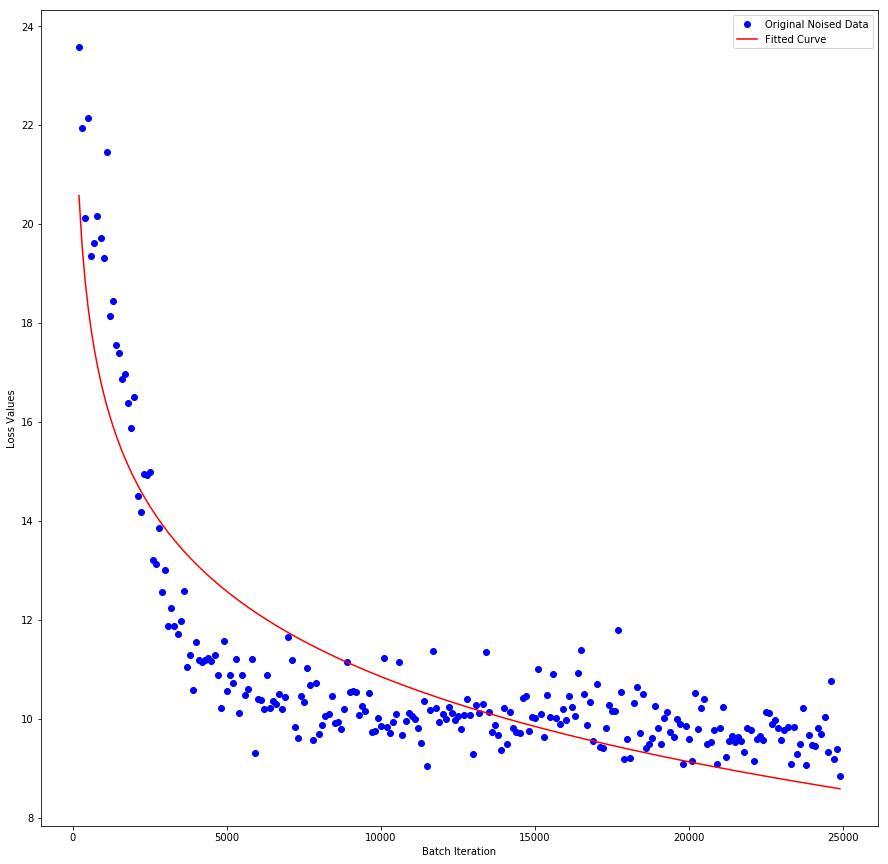

In [ ]:
def func(x_samp, a, b, c):
  #return a * np.exp(-b * x) + c
  return a * np.log(b * x_samp) + c


yn = y_samp + 0.2*np.random.normal(size=len(x_samp))

popt, pcov = curve_fit(func, x_samp, yn)


plt.figure(figsize=(15, 15))
plt.plot(x_samp, yn, 'bo', label="Original Noised Data")
plt.plot(x_samp, func(x_samp, *popt), 'r-', label="Fitted Curve")
plt.xlabel("Batch Iteration")
plt.ylabel("Loss Values")
plt.legend()
plt.show()

In [ ]:
!pip install statistics

  Created wheel for statistics: filename=statistics-1.0.3.5-cp27-none-any.whl size=7454 sha256=9cbc01353afa396b283a84b998e6d2b06ba22a283bc22fbd8378f757fbb6ce41
  Stored in directory: /root/.cache/pip/wheels/75/55/90/73aa7662bfb4565b567618547a275f01372a678ca92ecd64f3
Successfully built statistics


In [ ]:
import statistics
def variance(data):
  n = len(data)
  mean = sum(data) / n
  deviations = [(x - mean) ** 2 for x in data]
  variance = sum(deviations) / n
  return variance


In [ ]:
statistics.stdev(loss_value)

2.5935314236520295

In [ ]:
saver = tf.train.Saver()

#Save just in case
mname = 'model'+'_h'+str(n_hidden)+'nt'+str(num_timesteps)
save_path = saver.save(sess, "./tmp/"+mname+".ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: ./tmp/model_h600nt4.ckpt


## Training Ended
# Generative Part Starts Here

In [ ]:
#tf.reset_default_graph()
#imported_graph = tf.train.import_meta_graph("./tmp/"+mname+".ckpt.meta")

#saver = tf.train.Saver()
#restore_path = saver.restore(sess, "./tmp/"+mname+".ckpt")

#sess = tf.Session()
#imported_graph.restore(sess, tf.train.latest_checkpoint("./tmp/")
#imported_graph.restore(sess, "./tmp/"+mname+".ckpt")

In [ ]:
bars = int(25*16/num_timesteps)
print(bars, z_dim)
samples = sess.run(X_samples, feed_dict={z: np.random.randn(bars,z_dim)})
S = np.reshape(samples, (bars*num_timesteps, 2*note_range))
thresh_S = S>=0.7 #0.5
midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_chord_long")

(100, 600)


(1345, 156)


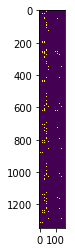

In [ ]:
vn = 3
q = "/content/drive/MyDrive/haydn/haydn3"+".mid"
# q = "/content/drive/MyDrive/naruto/n2.mid"
querysong = np.array(midi_manipulation.midiToNoteStateMatrix(q))
print(np.shape(querysong))
plt.imshow(querysong)

In [ ]:
song = np.array(querysong)
zeropadsong = np.zeros(((np.floor(song.shape[0]/num_timesteps).astype(int)+1)*num_timesteps, song.shape[1]))
zeropadsong[:song.shape[0],:song.shape[1]] = song
#song = song[:(np.floor(song.shape[0]/num_timesteps).astype(int)+1)*num_timesteps]
song = np.reshape(zeropadsong, [int(song.shape[0]/num_timesteps)+1, song.shape[1]*num_timesteps])
print(np.shape(song))

decode_bars = np.shape(song)[0]
S_reconstruct = np.reshape(song, (decode_bars*num_timesteps, 2*note_range))

midi_manipulation.noteStateMatrixToMidi(S_reconstruct, "out/song_reconstruct"+"_vf"+str(vn))   

(337, 624)


In [ ]:
# Encode the VAE on query
# These are the functions for Encoding-Decoding
# Encoding: Reading from Data to get z_sample
#z_mu, z_logvar = Q(X)
#z_sample = sample_z(z_mu, z_logvar)
# Decoding: Sampling from z
#X_samples, _ = P(z)

Xq = song
zs = True
if zs:
    zq_sample = sess.run(z_sample, feed_dict={X: Xq})
    ztype = "_zs"
else: #using the mean instead of sampling: 
    zq_sample = sess.run(z_mu, feed_dict={X: Xq})  #Check why this causes breaks / missing values in the output
    ztype = "_zmu"
print(np.shape(zq_sample))

(337, 600)


In [ ]:
# Decode with the z from query
samples = sess.run(X_samples, feed_dict={z: zq_sample})

S = np.reshape(samples, (decode_bars*num_timesteps, 2*note_range))
thresh_S = S>=0.66 #0.857 #0.5
fout = "generated_query"+'_h'+str(n_hidden)+'_nt'+str(num_timesteps)+str(ztype)+"_vf"+str(vn)
print(fout)
midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/"+fout)    

generated_query_h600_nt4_zs_vf3


(337, 600)


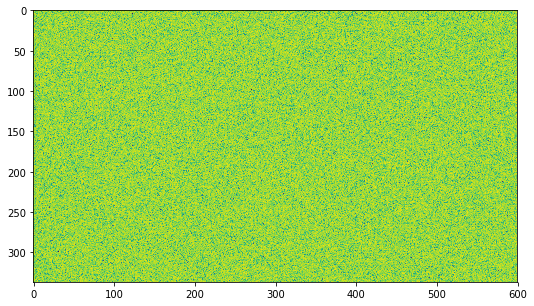

In [ ]:
plt.figure(figsize=(18,5))
plt.imshow(np.log(np.abs(zq_sample)))
print(np.shape(zq_sample))